# Setup

In [1]:
import Pkg

In [2]:
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/workspace/repo/code/SpinGlassExhaustive.jl/Project.toml`
  No Changes to `~/workspace/repo/code/SpinGlassExhaustive.jl/Manifest.toml`


In [3]:
using Random
using Distributions
using CUDA
using BenchmarkTools
using BinomialGPU
using StaticArrays
using Setfield
using Plots

In [4]:
N = 10

10

# Check chunk mapping

In [3]:
blocks = 3
threads = 4

for i in 1:threads
    for j in 1:blocks
        idx = (i - 1)*blocks + j
        println(idx)
    end
end

1
2
3
4
5
6
7
8
9
10
11
12


In [4]:
blocks = 3

threads = 4

function check_map!(x)
    idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x 
    x[idx] = idx
    @cuprintln(idx)
    return
end

x = zeros(Int32, blocks*threads) |> cu 

@cuda threads=threads blocks=blocks check_map!(x)

# x

1
2
3
4
5
6
7
8
9
10
11
12


CUDA.HostKernel{check_map!, Tuple{CuDeviceVector{Int32, 1}}}(CuContext(0x00000000059fd3f0, instance 7f8e4853d112ca9f), CuModule(Ptr{Nothing} @0x0000000006fa8620, CuContext(0x00000000059fd3f0, instance 7f8e4853d112ca9f)), CuFunction(Ptr{Nothing} @0x0000000007326840, CuModule(Ptr{Nothing} @0x0000000006fa8620, CuContext(0x00000000059fd3f0, instance 7f8e4853d112ca9f))))

## Algorithm

In [7]:
### Generate problem

In [7]:
N = 16

# graph = zeros(2^N)
graph = rand(Uniform(-5,5),N, N)
graph = graph * graph'

graph_dict = Dict()
for i in 1:N
    graph_dict[(i, i)] = graph[i,i] #rand(Uniform(-5,5))
    for j in i:N
        graph_dict[(i, j)] = graph[i,j] #rand(Uniform(-5,5))
    end
end

qubo = zeros(N,N)
constant = 0

for i in 1:N
    qubo[i,i] = 2 * graph[i,i]
    constant += graph[i,i]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph[low,high]*0.5
            qubo[i,i] -= 2*graph[low,high]
            qubo[low,high] += graph[low,high]*2
        end
    end
end

#############

qubo_dict = Dict()
constant = 0

for k in keys(graph_dict)
   qubo_dict[k] = 0 
end

for i in 1:N
    qubo_dict[(i,i)] = 2 * graph_dict[(i,i)]
    constant += graph_dict[(i,i)]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph_dict[(low,high)]*0.5
            qubo_dict[(i,i)] -= 2*graph_dict[(low,high)]
            qubo_dict[(low,high)] += graph_dict[(low,high)]*2
        end
    end
end

cu_graph = graph |> cu 
cu_qubo = qubo |> cu 

16×16 CuArray{Float32, 2}:
 204.98   36.086   23.786     17.4798  …   -94.9971    84.0564  -183.439
   0.0   222.545  -23.7396   -55.6413      174.169    174.234     26.0473
   0.0     0.0    641.802   -226.743       -57.2662   223.515     15.0895
   0.0     0.0      0.0      178.996       166.066    112.527   -169.882
   0.0     0.0      0.0        0.0          71.8063  -167.043     24.3291
   0.0     0.0      0.0        0.0     …   318.394     76.0824  -178.482
   0.0     0.0      0.0        0.0          91.8524   120.762     -7.63002
   0.0     0.0      0.0        0.0        -111.692   -121.647    163.512
   0.0     0.0      0.0        0.0        -123.537    -65.2732   -67.3383
   0.0     0.0      0.0        0.0         -81.1466  -167.928    221.232
   0.0     0.0      0.0        0.0     …    18.7869   -88.9361  -120.532
   0.0     0.0      0.0        0.0        -172.513    -12.5038  -169.577
   0.0     0.0      0.0        0.0          73.1202  -156.572   -106.652
   0.0     0.0    

In [8]:
res = Vector{Float64}()
#     res = Dict()

for (k, q) in enumerate(Iterators.product(fill(0:1,N)...))
    F = 0
    for i in 1:N
        F -= qubo[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= qubo[low,high]*q[i]*q[j]
        end
    end
    append!(res, F) 
#         res[k] = F
end

print(res)

[0.0, -409.9597598183333, -445.08922598654516, -927.2209518225253, -1283.6035162332314, -1741.1352177826786, -1681.2134625885817, -2210.9171301556757, -357.99219175952305, -802.9115586750336, -691.7987398965586, -1208.8900728297158, -1188.1096748932023, -1680.6009835398265, -1474.436943399043, -2039.1002180633147, -363.3251538332481, -984.0034228836745, -849.8464403282104, -1542.6966753962834, -1066.6388918298303, -1734.8891026113702, -1505.6808986935976, -2246.1030754927847, -660.0946161457136, -1315.7324922933171, -1035.3332247911662, -1763.143066956416, -909.9223210427434, -1613.1321389214604, -1237.6816500570012, -2013.063433953365, -72.34406332982896, -475.8875419638092, -1117.6094703470333, -1593.3249149986602, -748.508178754269, -1199.6235991193637, -1746.2943061402782, -2269.5816925230197, -825.133731010092, -1263.6368167412497, -1759.1164601777866, -2269.7915119265904, -1047.8118133349801, -1533.8868407972516, -1934.3152628714795, -2492.562256351398, -1274.9381486072639, -1889

, -4495.693252043505, -2773.9580268747277, -3584.776625217556, -3547.5603033808084, -4430.550867741286, -3529.50073788134, -4327.707001590233, -4239.299616169105, -5109.677845895649, -3010.779658379649, -3856.5578638196557, -3673.0992570362214, -4591.049428493877, -478.3491899678975, -1179.288341885082, -943.5551045845539, -1716.6662225193852, -1688.299902890326, -2436.8109965386243, -2106.0265378757877, -2926.7095975417324, -761.7765657386318, -1497.6753247529937, -1115.6998025057785, -1923.7705275377868, -1518.241245561508, -2301.7119463069835, -1824.6852026974602, -2680.327869460582, -1114.644009195609, -2026.3016703448866, -1621.2819843206826, -2605.1116114876068, -1744.304943881388, -2703.534546761779, -2203.4636393752667, -3234.865208273305, -1336.8486555192858, -2283.4659237657406, -1732.2039527948496, -2750.9931870589517, -1513.0235571055127, -2507.2127670830805, -1860.8995747498816, -2927.2607507450966, -472.48517676682263, -1167.0080474996541, -1537.867272414138, -2304.562109

 -3086.9438143237935, -4037.5829269170918, -2386.3762033384887, -3312.415291645254, -3027.3804301167547, -4025.591484441167, -3762.2303630196743, -4816.456411730241, -4603.428607787061, -5729.8266225152765, -3623.3425133067335, -4725.140503748415, -4417.061478442925, -5591.031434902256, -4377.973211635361, -5467.158867443104, -5107.888778553236, -6269.246400378632, -3785.599328822866, -4922.356926361725, -4468.035616109551, -5676.965179666057, -2041.3711361018825, -2270.4038229469325, -2012.1538450467394, -2313.3584979094358, -3752.1551010440985, -4028.759729620262, -3675.4585303577605, -4024.235124951571, -2159.53768206039, -2423.529976002617, -2019.037713155737, -2355.201973115611, -3416.835613903054, -3728.3998495763944, -3228.856365367206, -3612.592567058194, -2032.9360607532633, -2472.687256830406, -2045.1508302065376, -2557.0739923013275, -3163.43024745883, -3650.7533852670863, -3128.1657372809086, -3687.6608411068128, -2089.8798772647133, -2564.5906804390333, -1990.8119688684776

 -2858.447086764678, -3302.2201271886647, -3495.3392887210034, -3914.512304858457, -3753.202987676979, -4244.5479698320805, -3064.8088564280233, -3471.36953793154, -3258.869157165685, -3737.601804686849, -3553.5580038719677, -4007.6906271065986, -3700.139024978434, -4226.443614230712, -3949.1098467692614, -4531.429430407694, -4295.884885864849, -4950.3764355209305, -4311.055249076108, -4940.946774445655, -4610.351008540501, -5312.414499927696, -4399.591865572721, -5016.8710563083305, -4635.0842268188, -5324.535383572055, -4308.051234780016, -4972.902367246739, -4496.064316394899, -5233.08741487927, -2059.6633725957417, -2579.675451539643, -2050.56277017071, -2642.746815132258, -3696.794534227155, -4264.3785549021695, -3640.2146521709283, -4279.9706388635905, -2103.2651025654604, -2658.236788606539, -1982.881822290919, -2610.0254743496444, -3286.9102310973217, -3889.4538588695136, -3119.0476711915853, -3793.7632649814245, -2324.1979626415864, -3054.9285508175803, -2356.5294207249713, -3

 -4640.5055382464725, -5602.752343996402, -4248.459127460811, -5282.877899228385, -2743.1147790518144, -3405.6952455570054, -3068.5744462690964, -3803.326878791934, -3611.6971562845083, -4321.849564520812, -3889.6775438705945, -4672.001918124547, -3180.2547113135424, -3877.794784915911, -3394.4317006813144, -4164.143740301331, -3595.351055446684, -4340.463070780165, -3762.048765183261, -4579.332746534389, -4412.090183038032, -5285.389158775316, -4778.981910763733, -5724.452852518662, -4700.382782034077, -5621.253699502475, -5019.795230128581, -6012.838113614626, -4788.007385852703, -5696.265968687163, -5043.616435728892, -6024.046984580999, -4622.813951749194, -5578.64447631477, -4830.94372199419, -5858.94621257741, -1218.044149157345, -1882.0231004993743, -1258.3046445452778, -1994.4555619049538, -2442.1383914444555, -3153.689284517599, -2434.9196072011937, -3218.642466291984, -1911.3767332084685, -2610.315291647675, -1840.3545507468916, -2611.465075203745, -2681.984942396027, -3428.4

 -2746.4212104151597, -3842.27530575257, -3413.0396463676866, -4484.2937174185645, -3181.637011244497, -4325.063048313022, -3561.195146882489, -4619.836883299431, -3265.989113540985, -4396.802815975572, -3590.404194243469, -4696.617872391525, -3247.71888127077, -4426.104525436472, -1945.4216425681752, -2751.9689814714948, -2320.242407598423, -3198.9617125193877, -2400.9671004565666, -3255.0863810909987, -2728.308585855618, -3654.599832507698, -3032.2924289113075, -3873.7993749118036, -3295.8305160920445, -4209.509428110187, -3034.351853700146, -3923.4307414317555, -3250.4106612496885, -4211.661514998945, -3521.8003392411247, -4539.066187376536, -3938.053164779788, -5027.490978932849, -3397.056018892866, -4461.893808759391, -3765.8295648003345, -4902.8393206845085, -4547.448396137199, -5599.673851369791, -4852.418543826355, -5976.815965076596, -3969.218042689388, -5069.0154396530925, -4226.708910747348, -5398.678273728699, -1561.0701027916025, -2516.028446232483, -1621.4472868096468, -2

, -4298.248939739142, -3939.5417819444306, -5126.016342959247, -3575.541097093426, -4834.187624125888, -3796.2666958472273, -5110.928217265845, -3632.4600289853433, -5019.293516421609, -4205.308972996956, -5567.542436146688, -3994.0230265038786, -5428.428455671257, -4352.552460833772, -5702.173589349569, -4077.4631161223797, -5499.2562106558225, -4308.108704883951, -5705.30177513086, -3985.5400805413615, -5454.905116805919, -2460.166030582882, -3557.692761585052, -2855.1034842432387, -4024.802181263056, -2842.0586851604685, -3987.1573578937528, -3189.516859189632, -4406.787497940562, -3472.4720009372245, -4604.958339036573, -3756.1267767480726, -4960.785080865069, -3400.8786224152605, -4580.936902245721, -3637.0541185949137, -4889.284364443022, -4309.514392650294, -5617.759632884559, -4745.88390681907, -6126.301113070982, -4111.117268991232, -5466.934450956611, -4500.007503528813, -5927.996651511839, -5260.597633557582, -6603.802480889023, -5585.684469876848, -7001.061283225939, -4608.

, -5502.863471955556, -4460.306586980911, -5127.302741192478, -3649.3619760893002, -4388.530096318514, -5496.985861287527, -6211.553957230206, -4638.561970764722, -5425.302032725048, -4373.408458406429, -5216.163514752913, -3715.178585872746, -4630.105608236875, -5283.283987575949, -6173.610985653544, -4577.574835411068, -5540.073799506313, -4764.433393580751, -5642.148057024409, -3994.9208431975558, -4944.807472658862, -5220.822889650715, -6146.109494825487, -4403.831059636327, -5401.289630828746, -3251.783262014927, -3877.403527944963, -3152.297510003486, -3850.0897419511684, -4134.509168612303, -4807.701376273453, -3987.544136969667, -4732.908310648464, -4098.828402557045, -4759.408275584259, -3888.059972696093, -4620.811811740954, -4528.068276054869, -5236.220090813195, -4269.820566562723, -5050.144347338697, -4456.40172950601, -5292.740504668141, -4398.348038002986, -5306.858779182763, -4758.837857866738, -5642.74857475998, -4653.30488673252, -5609.387569643408, -5242.224140601073

-4456.5970942500035, -5557.46693752647, -6528.054818470824, -4830.442413483286, -5873.202260445288, -4518.637282063694, -5476.612828374113, -3727.8093598021937, -4757.956872130261, -5481.663753059506, -6487.211241101037, -4643.356551166813, -5721.076005225991, -4779.273634872467, -5913.008083317799, -4141.160450968892, -5347.066865431875, -5615.49636073118, -6796.802750907628, -4929.903897196414, -6183.382253390508, -5095.7337540579965, -6264.427809600506, -4346.337892304914, -5587.203913865072, -5478.4704468171585, -6694.736444090781, -4681.595305432882, -5970.033268724153, -3306.4706965555947, -4223.070354584483, -3227.101633174265, -4215.8732572208, -4115.5437998421685, -5079.71539960217, -3988.695456829643, -5025.039022607293, -4078.9510211089237, -5030.5102862349895, -3888.2992798780833, -4912.030511021797, -4434.5380912959445, -5433.669298153123, -4196.407070433909, -5267.710243308736, -4784.058829441144, -5911.376996702123, -4746.121826568231, -5945.611959846857, -5012.842154491

 -4023.273721611808, -4888.694656853127, -4736.975167072388, -5674.568068331355, -3132.947466690741, -4045.9403436631733, -3799.169632520127, -4784.334475510206, -1492.5468734147928, -2112.6739704573333, -1768.8104585462036, -2461.109521606391, -2061.0359539868123, -2728.7349927604673, -2289.820259487029, -3029.6912642783286, -2243.7938781602597, -2898.880582299977, -2408.77478544216, -3136.033455599524, -2358.7969256327265, -3061.4555715035567, -2476.2985532834327, -3251.12916517191, -2646.507097059606, -3477.3527033342384, -2964.202742699433, -3867.220314991713, -2634.7063993949764, -3513.1239474007216, -2904.9227654036085, -3855.5122794270023, -3336.531372358015, -4202.336585729824, -3542.944340148332, -4480.921519537787, -2871.2446415938316, -3784.6217966967542, -3030.1783297529546, -4015.727450873525, -1866.7833718885902, -2480.4941877467777, -2743.22313805066, -3429.1059199264937, -1827.8330516518183, -2489.1158092411197, -2656.793538182693, -3390.2482617896417, -3012.82785255479

, -5688.350466230979, -5412.010557928189, -6605.623244188828, -4056.4167208556682, -5225.429382829775, -4854.0382531646765, -6095.22288115643, -5495.813877828098, -6652.214205168268, -6229.632011918789, -7458.204305276607, -4531.834819596228, -5735.807088667511, -5218.173674055726, -6494.3179091446555, -2521.678586763693, -3432.7850759050853, -2818.058860525215, -3801.337315684254, -3016.5148640249104, -3975.193294897416, -3265.415858155237, -4296.266255045387, -3198.360775520371, -4144.426871758939, -3383.458371432383, -4401.696433688598, -3239.711019682035, -4233.349057651717, -3377.3293359628524, -4443.1393399501785, -3948.6084758029697, -5070.433474176452, -4286.420810072908, -5480.4177744640365, -3863.1549748275356, -5032.5519149321335, -4153.488029466279, -5395.056935588524, -4564.067935112588, -5720.852540583249, -4790.597591533016, -6019.554163021324, -4025.128401037603, -5229.484948239377, -4204.178777826837, -5480.707291046258, -2817.7070087065867, -3722.3972166636254, -3714.

, -4107.526077078563, -3831.7135919530956, -4377.660911006685, -3750.8946960671865, -4272.241990834242, -3901.378284346468, -4494.897545131171, -3871.848652845252, -4521.38290801611, -4222.526259113655, -4944.232480302159, -3862.188879732722, -4559.295076634694, -4165.38720636993, -4934.665369289549, -4635.491954873137, -5319.985817141172, -4874.886883292031, -5631.552711577711, -4172.346148661054, -4904.4119526602035, -4364.261797448752, -5168.499567465548, -3094.2915478342275, -3533.4915719034852, -2896.2486159239497, -3407.6206060108534, -4089.961077115231, -4576.733042915602, -3844.4388655737584, -4403.382797391774, -3605.712906778678, -4079.8725379451116, -3296.3872970188904, -3842.7188942029707, -4147.896402960128, -4669.627975857677, -3791.0915135691466, -4384.99505248434, -3876.4915422971726, -4526.410075598521, -3719.8806708953125, -4441.971170214306, -4291.871293341526, -4989.361768373989, -4087.7811423084695, -4857.44358335858, -4326.690171794565, -5011.568312193091, -4058.7

, -4897.307327486301, -4401.823202476473, -5251.362248262851, -4373.264261390407, -5138.019006525202, -4591.343817930995, -5428.2705290834365, -4416.755430104171, -5229.08211697008, -4587.355707013564, -5471.854359897118, -4958.896671576293, -5899.410318846003, -5329.690966474807, -6342.376579762163, -4875.58409515296, -5863.669684153783, -5198.899110420279, -6259.156665438749, -5647.9751576153885, -6623.448411982274, -5907.486774664393, -6955.131995048925, -5111.176548092502, -6134.221744190504, -5323.208885510313, -6418.426047625959, -3663.3663077090887, -4393.545723877196, -3485.4400644289226, -4287.791446614675, -4585.38303367929, -5363.134391578512, -4359.977510767928, -5209.900834684796, -4100.222850664751, -4865.361873930035, -3811.0139295350746, -4648.324918818004, -4568.753543535399, -5381.464508531797, -4232.065342774527, -5116.948273788573, -4718.535967566497, -5659.433892966698, -4582.0417847947465, -5595.111676212594, -5060.262915300049, -6048.7327824313625, -4876.28945289

, -4619.311604790958, -2658.4793050598955, -3532.241315495641, -3037.202637262958, -3983.13661371635, -2742.4195875289092, -3663.7535396957683, -3073.6636401007763, -4067.169558285282, -4058.5113746274537, -4967.232992160374, -4325.952028981005, -5306.845612531572, -3688.9656239969154, -4645.259183260949, -3908.9269987192724, -4937.392524000954, -3901.816223418666, -4986.296743086502, -4321.971616130144, -5478.624101815628, -3405.46672765103, -4537.519189049979, -3778.1428407313138, -4982.367268147911, -5240.625563539165, -6360.065690304182, -5549.4982784011345, -6741.110371183799, -4290.790034671978, -5457.802103168106, -4552.18346990275, -5791.3675044165275, -2637.2605078212796, -3511.406796387516, -2508.695362354077, -3455.0136169379603, -3146.2403144471773, -4067.958544744527, -2970.1958893487804, -3964.086085663777, -3723.847904858346, -4632.953800521756, -3484.000081541634, -4465.277943222692, -3779.3416783846915, -4736.019515779216, -3492.0145754367845, -4520.864378848956, -3599

, -6688.136147891954, -5054.266227995466, -6518.6739697748, -4735.600170825693, -6272.179878622674, -3797.291375536871, -4962.032778071467, -4196.131396370044, -5433.044764922286, -3807.5788546950816, -5019.892198960791, -4158.93959589706, -5443.424906180417, -5122.75862911564, -6322.459638747415, -5410.3159720993035, -6682.188947748725, -4679.560075174297, -5926.833026537186, -4919.638138526767, -6239.083055907302, -5313.597959290104, -6689.057871056795, -5753.870040631696, -7201.501918416032, -4743.595660211666, -6166.62751370947, -5136.38846192206, -6631.592281437511, -6577.8424834218185, -7988.262002285684, -6906.831886913897, -8389.423371795412, -5554.354151243827, -7012.345611838807, -5835.864275104711, -7366.0277017173385, -3531.0689848365387, -4696.1946655016245, -3422.620527999448, -4659.9181746821805, -3966.3959881516344, -5179.093610547835, -3810.4682516833486, -5095.337840097196, -4543.091565884815, -5743.176853647081, -4323.360431198215, -5595.617684978127, -4524.932536100

, -5945.184850195405, -4234.645532008941, -5251.746833002673, -5085.0398358699085, -6077.541112577107, -4271.950573028334, -5336.62381575318, -3706.9680300765954, -4399.802967539057, -3611.3848452379693, -4376.391748718077, -4218.088761254594, -4958.49564044817, -4075.0262967847743, -4887.605141995996, -4867.174453843138, -5594.968998402778, -4660.308591155001, -5460.275101732289, -4924.809151921584, -5700.1756382123385, -4670.464009602254, -5518.002461910653, -4578.544719253498, -5482.098165948054, -4524.393594923288, -5500.119007635491, -4509.3756721948475, -5460.501060620516, -4407.745268233443, -5431.042622676759, -5677.528413572985, -6616.041467364716, -5512.094611393266, -6522.779631202643, -5154.873333414782, -6140.958328937626, -4941.960251603868, -6000.2172131443585, -4063.6897990132015, -4756.909014606153, -3460.8181365043115, -4226.2093181149085, -4999.850054348085, -5740.641211672151, -4349.499112207998, -5162.462235549712, -4910.451550249251, -5638.630372939381, -4196.2972

 -5955.623558158836, -7191.532285233773, -5210.130263578568, -6518.210956671152, -5966.7550754986205, -7250.235744304671, -5173.78250128716, -6529.435136110857, -4385.723147079533, -5369.537476640847, -4310.256650871018, -5366.242946449979, -4823.191074946728, -5854.577346239156, -4700.2452991070195, -5803.803536417094, -5471.364754857289, -6490.138691515777, -5284.615580799262, -6375.5614834754, -5455.346649624932, -6521.692528014535, -5221.118195935712, -6359.636040342961, -5530.2695016509015, -6724.8023404443065, -5496.235065950803, -6762.939870761856, -5387.447651281446, -6629.552431805966, -5305.933935950154, -6620.210682492321, -6554.688379981597, -7784.18082587218, -6409.37126643199, -7711.0356783402185, -5958.380496512591, -7235.444884134287, -5765.584103331787, -7114.82045697113, -4497.441322554421, -5481.639930246227, -3914.6863486756442, -4971.0569223850935, -5359.9487745785045, -6391.719324001422, -4729.7145210685285, -5833.657036509094, -5269.638257801686, -6288.7964725906

 -3717.0608125954554, -4235.568112124312, -2730.354045210095, -3224.2613204524205, -3585.429441892215, -4151.508683152186, -3717.3637248112004, -4339.457960457326, -4772.63313948244, -5466.899341146215, -3506.4078886020575, -4176.074065979297, -4514.198023642102, -5256.036167036991, -4836.059906318452, -5493.113749061757, -5780.046643140184, -6509.272451901135, -4171.618037009755, -4876.243821484174, -5068.125494200292, -5844.923244692359, -820.9169196589584, -1195.899111608006, -1255.8404532712066, -1702.9946112379002, -2011.2784702677682, -2433.832603947929, -2398.722724248821, -2893.4488239466277, -1428.4293149720816, -1838.3711140183054, -1752.0701707348194, -2234.183935798691, -2165.3048324813385, -2622.8185732586758, -2441.4664086128814, -2971.1521154078655, -1334.5215294124, -1920.2222305935402, -1810.8771235330646, -2468.7497907318516, -1944.5933017845591, -2577.865944696813, -2373.4696162740297, -3078.9142252039296, -1880.8111952784652, -2501.471503556782, -2245.8841115496202,

 -1986.351613123952, -2688.706731636837, -3020.305655916887, -3794.832740447419, -2282.032751840655, -3031.959812084654, -3268.5075150023954, -4090.6065412640414, -3091.705708089472, -3829.0204336995353, -4014.3770730328974, -4823.863764660607, -2933.9008137066226, -3718.7874810477997, -3809.0928990188536, -4666.151532377677, -4342.097778001783, -5255.171405746762, -5417.483881303136, -6402.729475065763, -4057.489138481836, -5018.13470795793, -5085.395962151994, -6118.213497645736, -5386.229143520247, -6334.262378362404, -6350.33256897209, -7370.537769831893, -4648.134470900748, -5643.739647474018, -5564.758616721397, -6632.5357593123135, -1710.1109979466225, -2376.0725819945205, -2165.151220188981, -2903.2847702545264, -2826.819745244628, -3540.3532710236404, -3234.380687855793, -4020.086179652451, -2243.058577270956, -2943.9797684160317, -2586.8161216638055, -3359.9092788265284, -2906.28129146941, -3654.774424345599, -3202.559556231065, -4023.2246551248995, -2496.6852730945275, -3373

, -4567.444577393407, -4513.403501881083, -5043.518494566569, -4335.428260999271, -4937.715219702406, -3134.1029789940344, -3364.5516324347855, -3673.6338161151702, -3976.2544355735686, -3930.6173697305258, -4208.63796490239, -4422.668927220467, -4772.86148840998, -4074.1962441473283, -4339.604504685256, -4502.444403418955, -4840.02462997453, -4417.224601784266, -4730.20480405331, -4797.993481424699, -5183.145649711389, -4845.119249295537, -5286.286411968381, -5426.082146925089, -5939.421275615581, -5061.343861795377, -5550.082966199337, -5594.8274797937365, -6155.738550215341, -5723.989785001773, -6200.116554771795, -6193.670004781817, -6741.968740569486, -5486.728364402063, -6010.427075903198, -5908.929304550911, -6504.799982069693, -2979.152132497417, -3173.2072514731803, -2939.7691490679754, -3205.9962340613865, -4596.694131815212, -4838.321192522089, -4509.831868754577, -4823.6308954791, -3346.8388820095233, -3575.8536080824642, -3196.1732207305727, -3497.3599128211613, -4510.8948

 -4605.472973729594, -5463.779717434405, -4311.545881930663, -5085.068324983888, -4201.1666093101585, -5046.861018381029, -4608.07105882894, -5429.165443613279, -4450.212506577242, -5343.478857379227, -3025.8104133161164, -3547.2384588557197, -3585.457939067364, -4179.057950624613, -3748.6720007418044, -4317.671988012521, -4260.840246861857, -4902.01220015022, -3891.3388624806216, -4447.7265151174015, -4339.7037103823595, -4968.263329036787, -4160.714416806758, -4764.674011174651, -4561.5999850773, -5237.731545462841, -5009.796349012082, -5741.942903783778, -5610.875935271748, -6415.194456061088, -5152.36815820112, -5932.08665470393, -5705.968464829591, -6557.8589273500465, -5814.10206872953, -6581.208230598402, -6303.898977139684, -7143.177105026204, -5503.1878448190155, -6317.865948419002, -5945.505473597976, -6832.35554321561, -3408.2892573110416, -3893.323768385658, -3389.0229625117117, -3946.2294396039742, -4952.178453318034, -5484.784906123763, -4885.43287888751, -5490.2112977108

, -3877.1786814870534, -2668.4739162889005, -3551.003624643076, -2718.738419330871, -3673.440093702692, -3005.448206942427, -3935.5498570277155, -3008.233430353202, -4010.507046456139, -3727.713014167012, -4645.202329618365, -3666.694839359472, -4656.356120828471, -3611.2012717209864, -4576.262528903454, -3502.7038172822517, -4539.937040482366, -2281.3488337275307, -2946.743751665261, -2890.3574572917423, -3627.9243412471187, -2591.1735018089157, -3304.140361477759, -3152.7028457419324, -3937.8416714284235, -3796.6081369734397, -4496.962662008346, -4294.334082688141, -5066.860573740695, -3652.946771955272, -4400.873238721293, -4103.193438038779, -4923.291870822447, -4172.738062110226, -5048.851489280049, -4823.1787461828535, -5771.464139370327, -3902.2729519549625, -4825.958320855898, -4505.234356396394, -5501.09169131498, -5626.77463590908, -6537.847670176081, -6165.9326421322, -7149.177642416847, -4902.823492654261, -5861.468468652377, -5394.502219246187, -6425.3191612619485, -1658.9

, -3818.6184634253113, -2956.8998586801554, -3954.650056998267, -2874.5663119943097, -3944.488476330069, -3347.025091159975, -4392.347231209203, -3217.212264842935, -4334.706370909807, -3236.0928096767475, -4409.601910129774, -3306.4740013488286, -4552.155067819502, -3499.414297019471, -4720.495339203612, -3522.3162090603573, -4815.569217262147, -4220.767091566069, -5429.235799116278, -4179.8656053886425, -5460.5062789564945, -4030.602545809242, -5286.643195090563, -3942.2217800006174, -5270.434395299585, -2497.789985190011, -3454.1642952265915, -3126.915297384333, -4155.461573438561, -2733.961849960593, -3737.9081017282874, -3315.6078825237205, -4391.726100309062, -3938.4844724471304, -4929.818389580891, -4456.327106791945, -5519.832989943351, -3721.1703041181604, -4760.076162983034, -4191.533658831779, -5302.6114837142995, -4662.148878967169, -5829.241698235846, -5332.7062516699125, -6571.9710369562345, -4318.030965501102, -5532.695726500892, -4941.10905857265, -6227.945785590087, -6

 -2983.542417515336, -3546.5985096817835, -4793.461009622633, -5331.917077502548, -4280.507655483301, -4891.135689380864, -4329.652673547625, -4855.496406793604, -3752.895921189981, -4350.911620453605, -5220.611158047237, -5794.026833024328, -4596.375126058396, -5241.9627670531345, -4129.376559780114, -4830.979195161008, -3705.3345457803966, -4479.109147178935, -4893.531299142627, -5642.705876254633, -4422.010005511713, -5243.356548641367, -4948.790011857213, -5685.352254335283, -4413.465320007983, -5222.199528503701, -5259.458718120173, -6043.592902329355, -4676.654746639749, -5532.960896866579, -3605.5492041662214, -4090.0170491306694, -3740.2513106887454, -4296.89112167084, -4342.554320956591, -4874.594107652152, -4429.777147847919, -5033.988900561128, -4880.982861611117, -5400.410313672742, -4904.40229028413, -5496.001708363403, -5164.501945301935, -5731.501339094672, -5140.4420943437535, -5779.613454154139, -5125.178203367052, -5820.364557563592, -5301.312370397994, -6068.67069061

 -3283.608766542818, -4065.472284790469, -2838.251380664794, -3692.286864930092, -4554.400480831176, -5383.835940809941, -4061.5638153219566, -4963.1712413183695, -4089.6801320781838, -4906.503257423013, -3533.04006835065, -4422.035159713124, -4906.98581326699, -5771.380880342933, -4302.86646990826, -5239.433503001851, -4236.938499693923, -5229.5205271736695, -3833.013174324317, -4897.767167821709, -4927.440435745634, -5967.594404956492, -4476.035830744831, -5588.361765973337, -4981.787135782233, -6009.328770359156, -4466.579132563114, -5566.292733157686, -5218.80303873439, -6293.916615042424, -4656.115755884078, -5803.40129820976, -3361.9334021546642, -4137.380639217963, -3516.752197307299, -4364.371400388242, -4025.285715634232, -4848.304894428643, -4132.62523115567, -5027.816375967731, -4562.802243610769, -5373.209087771247, -4606.338360913895, -5488.917171092019, -4772.668523990785, -5630.647309882374, -4768.725361662714, -5698.876113571951, -5154.532066749959, -6140.69781304535, -

, -6977.275840113923, -4196.899011097927, -4968.739467104771, -5097.309035461278, -5941.32145748577, -1450.783994447056, -1929.7586705240071, -1961.2354381124312, -2512.3820802070295, -1873.55228521207, -2400.0989030201354, -2336.5244492462493, -2935.2430330719626, -2630.4195160952995, -3144.3537992694282, -3029.588281911165, -3615.6945311029403, -2599.701773760761, -3161.2079986660033, -2951.3912599454316, -3585.0694508683214, -2919.7547498016165, -3609.4479351106597, -3471.6382539754077, -4233.503405302098, -2762.2332623299803, -3499.4983893701374, -3266.6374868725775, -4076.0745799303822, -4038.167542002801, -4762.820334409022, -4478.768368327083, -5275.5931267509495, -3427.160021431613, -4199.384755568948, -3820.2815681247002, -4664.678268279682, -2737.8288654082103, -3210.387260300808, -3848.456490104244, -4393.186851014489, -2553.1577553644315, -3073.2880919881445, -3616.3061004292717, -4208.608403070631, -4312.261862977193, -4819.7798649669685, -5311.6068098237165, -5891.2967778

, -5421.5367528163715, -5425.485902650826, -6525.51810967699, -6407.1829754900655, -7422.430881864646, -7375.188968114722, -8462.608840506948, -5297.483127451188, -6360.302975556885, -6218.009840444652, -7353.001654567994, -2181.6124712437304, -2951.5665394195335, -2712.180603539217, -3554.306637732667, -2530.7279586979416, -3348.253968604857, -3013.8168113622323, -3903.5147872867965, -3286.6831769031855, -4091.5968521761647, -3705.968631349162, -4583.054272639788, -3182.3126312578433, -4034.798248261937, -3554.1188060726254, -4478.776389094366, -3923.552891992754, -4904.225469400648, -4495.5530847966575, -5548.397628222198, -3692.3786012103146, -4720.623120349323, -4216.899514383023, -5317.315999539679, -4967.400868205151, -5983.033052710222, -5428.118383159544, -6515.922533682261, -4282.740544323159, -5345.9446705593455, -4695.978779646358, -5831.35487190019, -3390.4492656739803, -4153.98705266543, -4521.193579000126, -5356.90333200922, -3132.1253523193996, -3943.2350810419625, -4215

, -5179.353055353877, -5255.836685950973, -5836.390486173891, -4515.590658229071, -5071.544434165455, -5052.9768434002435, -5681.102585354275, -5863.003040079269, -6406.344481381717, -6336.585827032127, -6952.09923435222, -5254.136444060182, -5845.049827093742, -5680.239951381845, -6343.325300433052, -3070.3674198584304, -3368.415022962098, -3106.5123464821168, -3476.7319156034314, -3920.3161593324285, -4265.93570416721, -3908.98180632492, -4326.773317177347, -4010.177295705658, -4343.184505906503, -3935.039544479835, -4340.218720698326, -4406.640002080104, -4787.219154012062, -4284.022971223086, -4736.77408917269, -4167.577946031122, -4676.344058366883, -4245.154933163227, -4826.093011516631, -4437.236907268471, -4993.574961335345, -4467.334614769379, -5095.844634853901, -5046.165092431292, -5589.89081186423, -5012.459401713886, -5628.357087164471, -4862.338020569089, -5453.63568173314, -4781.153050220487, -5444.622677402186, -3848.9497885851933, -4140.581110504509, -4485.27089623954,

 -5290.020092684684, -6033.366324602651, -5459.716003327424, -6259.077229631545, -6064.698156759902, -6936.231349081669, -5230.682637097086, -6077.615805132319, -5788.185510898369, -6707.29064495125, -6577.183006269296, -7411.503839670594, -7070.882481852264, -7977.375281271209, -5894.663606939406, -6776.556382071817, -6340.8838028911805, -7294.948544041238, -3341.138943181066, -3930.1659383835863, -3397.4005584348643, -4058.5995196550302, -4117.43487934426, -4754.033816277894, -4126.217214966863, -4834.988117918143, -4206.384003039505, -4830.370605339201, -4151.362940443793, -4847.521508761136, -4529.193906103148, -5200.752450133959, -4426.693563876242, -5170.424073924698, -4711.319134748221, -5511.064639182834, -4809.012810510437, -5680.930280962694, -4907.325292674768, -5754.642738840494, -4957.539688805787, -5877.02910098916, -5515.341465159604, -6350.046576691392, -5501.752463072308, -6408.629540621745, -5257.861589986596, -6140.138643249499, -5196.7933082681075, -6151.24232754865

 -5227.568761354181, -6067.30992393916, -4210.6737080291205, -5025.8148463275675, -4664.822941285443, -5552.136045601535, -4455.867112064846, -5399.195210767094, -5110.210363310289, -6125.710428030186, -3813.7968264902056, -4804.6968669235675, -4420.660798104454, -5483.732804555463, -6223.064969088125, -7201.352674887551, -6766.125542484059, -7816.585214301132, -5127.50865041393, -6153.36829794447, -5623.089944178669, -6721.121557726857, -2368.2647001883083, -3101.258567788956, -2473.887413255071, -3279.053246873366, -2731.5237170072014, -3512.0895263389625, -2789.667150442769, -3642.4049257921774, -3883.2406141281526, -4651.194088825974, -3877.5806493454056, -4717.706090060875, -3793.0135978474923, -4608.539014276428, -3739.874353433551, -4627.571735880132, -3645.8481844421963, -4589.560561274933, -3792.9029580173765, -4808.787300867759, -3428.81742302444, -4420.10174158829, -3528.392916968424, -4591.849201549921, -5099.60136893498, -6078.273352864898, -5135.373464660651, -6186.217414

 -4188.143785008229, -5331.476674325996, -5491.884266402626, -6550.4328550688115, -6013.629467920254, -7144.350022604085, -4902.96492265428, -6009.085453051579, -5377.2308445407125, -6555.5233409556595, -5569.345611384061, -6803.6531021851615, -6243.805551259617, -7550.285008078363, -4853.622522498615, -6135.501955030832, -5480.603182742975, -6834.654581292839, -7261.978652418551, -8531.245750316828, -7825.155914444596, -9166.594978360517, -6092.769530433555, -7409.608570062946, -6608.467512828404, -7997.478518475443, -2963.769940651344, -3987.74320035084, -3089.5093423482176, -4185.654568065363, -3253.3761541594326, -4324.921355590042, -3331.6362762251115, -4475.353443673368, -4404.181038602397, -5463.113905399073, -4418.637762449762, -5549.742595264081, -4240.301219010935, -5346.806027538724, -4207.278663227104, -5385.955437772539, -4514.323090299693, -5749.0148592312835, -4681.494552504984, -5988.358287454223, -4223.639525571134, -5505.9032362338385, -4343.331708145229, -5697.767384

, -4928.501537603949, -4420.372473440108, -5091.798897685739, -5552.44207867429, -6139.08420226834, -5579.764074520118, -6238.578164131814, -5464.355986945731, -6098.570052270895, -5444.198703160364, -6150.584734503174, -5150.43435889162, -5912.835384620586, -5330.471093095374, -6165.044084841988, -4935.5445220259635, -5745.517489486043, -5068.101976598523, -5950.24691007625, -6677.806570113883, -7475.167202940027, -6746.560626468128, -7616.093225311919, -6009.430700148674, -6854.36327470593, -6030.705476871724, -6947.810017446628, -3812.532742372171, -4364.599536999533, -3443.848938397246, -4068.087699042256, -4602.972207900048, -5202.610944258525, -4186.809124293927, -4858.619826670049, -5087.6830105109975, -5674.709412235538, -4607.716528686563, -5266.914896428749, -5424.636442939323, -6059.234786394979, -4897.190681483692, -5603.9609909569945, -4718.35599744419, -5481.141301303645, -4391.104253977681, -5226.061523854783, -4928.505684735418, -5738.862930325989, -4553.7746616377135, 

 -4636.046156515871, -5526.2800068427105, -4747.288239210126, -5709.6940555546125, -5858.329143136214, -6735.950658829117, -5905.767827612154, -6855.561309322702, -5696.5902480968525, -6621.783705520867, -5696.549652941595, -6693.9150763832595, -5803.855904736798, -6857.236322564614, -6004.009327570663, -7129.561711416127, -5515.313264560338, -6616.265624119268, -5667.987407763008, -6841.111733339588, -7256.663299970271, -8345.003324895264, -7345.534044954628, -8506.046035897267, -6514.634626694259, -7650.546593350367, -6556.02609204742, -7764.110024721175, -3947.9810293611667, -4791.027216087381, -3599.4139140163534, -4514.632066760212, -4664.767691578241, -5555.38582003557, -4268.721296602231, -5231.511391077207, -5148.566481511205, -6026.572275334599, -4688.716688316881, -5638.89444815792, -5411.867110628728, -6337.444846183235, -4904.538037803208, -5902.287739375362, -5126.7739498276505, -6180.5386457859595, -4819.638894991251, -5945.575556967207, -5263.2708338080765, -6364.6074714

, -3564.954437717658, -2693.346420116315, -3840.699417025581, -1198.177053234128, -1973.69174488101, -2119.2561445273504, -2966.9428021918793, -2311.4730887911164, -3134.5597221691123, -3185.072900453143, -4080.331499848786, -2189.6652670997673, -3000.139565843827, -2999.46168054348, -3882.107945305186, -2849.4752695572042, -3707.5215100323767, -3611.792403369722, -4542.01060986254, -2244.749641346727, -3230.9828422257015, -3207.2607931483662, -4265.6659600449875, -2777.7558986670656, -3811.561041277154, -3692.78777083751, -4798.764879465246, -3175.0151257653097, -4196.207933741461, -4026.243599717438, -5119.608373711237, -3254.5353499860958, -4323.300099693361, -4058.284544307029, -5199.221260031943, -1420.1068715162364, -2196.005841293609, -1833.8974851391945, -2681.968420934215, -2958.44243123011, -3781.913342738596, -3324.7537652218725, -4220.396642748006, -2098.1504128513843, -2909.008989725934, -2400.658348624833, -3283.6888915170293, -3182.999939465705, -4041.430458071369, -3438

 -3186.729807273625, -4517.930623166917, -3521.702187043521, -4925.074968954462, -2580.8401449643507, -3899.4286262237065, -2852.0091265159326, -4242.769573792936, -3194.1469666831263, -4560.307389673597, -3417.8366686035133, -4856.169057611629, -1699.5904904654394, -2766.0845742111724, -2640.786270388773, -3779.4523201521524, -2739.233722711625, -3853.299748188472, -3632.9502230037624, -4819.188214498257, -2616.5138883422896, -3717.9675791852005, -3446.4269904161138, -4620.0526472766705, -3202.671087488923, -4351.696720062947, -3985.1049099315524, -5206.302508523222, -3019.132743972502, -4296.345336950328, -4001.760584404252, -5351.145143399724, -3478.486197982037, -4803.270732690977, -4413.634758782592, -5810.5912595091795, -3874.833412402295, -5187.005612477297, -4746.178574984535, -6130.522741077183, -3880.7008333122776, -5240.444975118395, -4704.5667162633235, -6136.482824087087, -1676.516715285832, -2743.3950771620557, -2110.424017538901, -3249.4743454327727, -3141.199471688901, 

 -4722.225622967042, -5477.933037670931, -2818.639670594321, -3630.3620796843657, -2706.668124323613, -3590.5624994313043, -4386.265777432436, -5245.560128253594, -4226.814951530532, -5158.281268369337, -3114.2820332911474, -3960.9640494783694, -2891.02780917093, -3809.881791375798, -4228.42210702971, -5122.676064948046, -3957.688603278298, -4924.1145272142785, -2612.768677477307, -3207.3562961509056, -3059.541251728841, -3726.3008364200864, -4153.24516174328, -4795.404722147992, -4552.538456363618, -5266.869982785978, -3364.431245541931, -3993.978471312707, -3699.921141943955, -4401.640333732377, -4451.421696708352, -5128.540864210241, -4739.432313479181, -5488.723446998716, -3287.5810364080385, -4092.8871643137304, -3775.78567116799, -4653.2637650913275, -4247.767742437362, -5100.645812074168, -4688.493097566117, -5613.543133220572, -3978.0208750256056, -4818.2866100284755, -4354.942831936046, -5267.380532956562, -4484.721547955376, -5372.559224689359, -4814.164225234623, -5774.17386

 -3587.8914891693535, -4521.082733082537, -4252.796696132127, -5161.387915758779, -4575.650300264986, -5556.413485909284, -2614.1752727642556, -3650.953452794709, -3137.2228948862353, -4246.1730409343345, -3522.6096183539853, -4606.959740115552, -3998.1779608447696, -5154.700048623985, -3552.6923176327264, -4624.430104760357, -3964.4572619051964, -5108.367015050474, -4007.640630122904, -5126.950358981649, -4371.926294764179, -5563.40798964057, -2484.5649974355083, -3304.208387049516, -3566.356740079729, -4458.172095711384, -3365.8497204530963, -4233.065051798218, -4400.162183466123, -5339.549480828891, -3879.1022476717767, -4733.7052443829625, -4849.611312466488, -5776.38627519532, -4306.900937589812, -5209.075876032111, -5229.930722753329, -6204.277627213274, -3720.1903705541786, -4750.552269400279, -4843.414173706817, -5945.948038570566, -4021.1853153351176, -5099.119155912332, -5096.92983885656, -6247.035645451424, -5053.504891343389, -6118.826397286669, -6065.44601664652, -7202.939

, -4481.459526733675, -3771.1014927178294, -5007.884463363801, -2826.952159916515, -3978.950829910903, -3217.4017323106787, -4441.572368322713, -3788.5374473325382, -4988.10805905804, -4131.507740095507, -5403.250317838657, -2571.1033086587217, -3898.8608807880264, -3114.267619410813, -4514.197157557763, -3405.884850937648, -4781.2143647980665, -3901.569882058544, -5349.07136193661, -3435.0555375384033, -4797.772716764886, -3866.9371704409846, -5301.8263156851135, -3816.351046717778, -5226.640167675375, -4200.753399989165, -5683.214486964408, -2090.3152914046077, -3200.9380731174665, -3192.2237226789402, -4375.018470409445, -2897.947211111393, -4056.141934555365, -3952.37636275453, -5182.743052216149, -3410.287725652087, -4555.870114462123, -4400.913479076909, -5618.667833904594, -3764.43361225932, -4957.587942800468, -4707.580086052947, -5972.906382611744, -3598.9103299177405, -4920.251620862693, -4742.250821700491, -6135.764078663092, -3826.2524713878765, -5195.165704063941, -4922.11

 -3782.7893988652922, -4500.093962708016, -5691.384926828782, -6384.089466384973, -5651.214691769462, -6416.0911973432985, -4535.39448280793, -5215.486687730186, -4431.420849530296, -5183.685020470196, -5997.813022243742, -6725.477168897111, -5846.3601093349125, -6646.196222005928, -3800.0765667860346, -4655.9276738432045, -3848.8176718663262, -4776.840744941143, -5135.691361084747, -6039.114409873034, -5136.953186533844, -6112.548201339777, -4498.76796585349, -5389.578680007838, -4436.226393084272, -5399.209073256266, -5380.896727052653, -6319.279382938114, -5270.875874652239, -6281.4304965553465, -3533.7640184047646, -4172.480335045489, -4141.249244007297, -4852.137526665668, -4842.229190131337, -5528.517448503174, -5402.235136102675, -6160.695360492161, -4688.475622840017, -5362.15154657792, -5184.678170593042, -5930.52606034859, -5543.454761467038, -6264.702626936053, -5992.178029588867, -6785.597861075529, -4397.629162341568, -5247.063988214385, -5046.546448452519, -5968.153240342

, -3935.4937612433114, -3026.807504521369, -4035.0914604629434, -4841.633540543943, -5825.317472198986, -4821.579994114733, -5877.435891787424, -3684.7310838451076, -4655.802680866212, -3600.8741391975836, -4644.1177022363345, -5073.496819970115, -6092.140358722335, -4942.1605956913945, -6032.976100461264, -3296.947649206463, -4443.778148362483, -3365.805442916866, -4584.807908090533, -4558.9096401943725, -5753.312081081508, -4580.28815427358, -5846.8625611783655, -3921.07423228513, -5102.864338538328, -3878.649348146023, -5132.611420416867, -4729.550190173487, -5958.912238157803, -4639.646026403186, -5941.180040405147, -2679.4573588998264, -3609.153067639402, -3307.05927313247, -4308.926947889692, -3914.269727315596, -4891.537377786283, -4494.392361917045, -5543.831978405381, -3759.6041473462906, -4724.2594631830425, -4275.923383729425, -5312.750665583823, -4540.9304826625075, -5553.157740230375, -5009.770439414447, -6094.1696629999615, -3816.292168231092, -4956.70638620276, -4485.326

 -4502.900392831051, -5501.16128653182, -1302.1453256375212, -1935.3684733907498, -2285.3798883829054, -2990.775002153782, -2296.373671338738, -2977.168760823081, -3232.1289544529286, -3985.096009954919, -2361.058794276124, -3029.2415491265297, -3233.010679171999, -3973.365400040052, -2901.8011068777882, -3617.5558034593087, -3726.2737121424693, -4514.200374741635, -2115.3522257280542, -2959.2938827133767, -3140.0188489818574, -4056.132471984826, -2529.2907931926215, -3420.8043919090583, -3506.4781368152294, -4470.163701549312, -3113.0429649196003, -3991.944229002099, -4026.426910323892, -4977.500140424036, -3073.4954992846147, -3999.9687050982275, -3939.4001650577125, -4938.04533688897, -2190.9411485672717, -2817.748015136148, -3774.351892343316, -4473.330724929838, -2577.730093459697, -3252.108901759687, -4113.661557604547, -4860.212331922182, -3644.6520931266145, -4306.418566792667, -5116.780159053146, -5850.718598736845, -3577.9550049194872, -4287.293420316653, -5002.603791214825, 

 -4341.108455536858, -5595.3891342393, -4157.840301350244, -5327.336679401103, -5598.629413054911, -6840.297757123416, -3619.6005082475717, -4836.668828029545, -5012.910340321043, -6302.150626120662, -1422.2829449408146, -2346.485484792894, -2425.6341963163104, -3422.008702186038, -2342.8584873312275, -3314.6329689144227, -3298.7304590755307, -4342.676906676369, -2406.6315975906277, -3365.793744539885, -3298.700171116615, -4330.034284083518, -2873.721106881489, -3880.455195561861, -3718.310400776281, -4797.216455474297, -2508.459510425812, -3643.380559509985, -3553.242822309725, -4760.335837411542, -2848.745274579576, -4031.2382653948634, -3846.0493068322944, -5100.714263665225, -3431.585433628568, -4601.466089809916, -4365.08606766297, -5607.138689861964, -3318.3851646827793, -4535.837762595242, -4204.406519085987, -5494.031083016095, -2232.8706913396604, -3150.656950007388, -3836.398123745816, -4826.356348431188, -2546.0068329212822, -3511.365033320124, -4102.054985696243, -5139.5851

, -3540.67041392392, -3935.6886919247504, -4670.490963823944, -3294.1196000590394, -4004.3218476717016, -4304.288904310222, -5086.66311794053, -3949.349873963394, -4646.939786942117, -4895.715779996261, -5665.477658992631, -3911.9433328805085, -4657.105187590347, -4810.82995928218, -5628.163780009667, -2646.72740157946, -3099.0234763594053, -3155.655447283157, -3680.1234880807483, -4068.1361959896617, -4568.0042125007185, -4529.584962062161, -5101.624944590867, -3465.815224417047, -3953.0709062941696, -3863.460592271234, -4422.888240166001, -4433.737985727696, -4968.5656093359285, -4783.904073950685, -5390.90366357657, -3088.1740724881265, -3751.188656500164, -3638.5341787002403, -4373.7207287299225, -3929.293088661678, -4639.879614404828, -4432.173915242594, -5214.932407003393, -3846.039165878655, -4544.013356987869, -4285.116594241259, -5055.262751368116, -4233.6721489526535, -4979.218281792982, -4625.270297684061, -5442.988396542038, -3027.06072227482, -3472.9405158704126, -4136.164

, -4413.534581408896, -4465.6830983556665, -5363.277801949909, -3056.0940327278086, -4009.7037307082064, -4133.859305240296, -5159.64096923834, -3398.520721433671, -4399.702361145184, -4428.806714314964, -5502.160320044124, -4052.8389826600396, -5041.408287737615, -5019.321577323017, -6080.062848418238, -3941.7796382663523, -4977.92088507504, -4860.782953298134, -5969.096166124471, -2306.8080674087155, -3050.0835342875116, -2835.8528017425238, -3651.3002346389662, -3654.564058508114, -4445.411467118021, -4136.129513210725, -4999.148887838281, -3051.331074257513, -3829.566148233487, -3469.093130741812, -4319.5001707354295, -3945.601032257359, -4771.4080479644435, -4315.883809110461, -5213.862790835194, -3021.2244037118444, -3975.2183798227334, -3591.70119855407, -4617.867140682603, -3788.6906165745936, -4790.256534416594, -4311.6881317856205, -5385.426015645273, -3704.524681113584, -4693.4782643216495, -4163.718798106301, -5224.844347332009, -4018.504860876781, -5055.030385815959, -4430

 -4954.723390152255, -5948.713024413512, -4036.5052726833883, -5005.894882658113, -4963.437625019719, -6004.9992010120895, -3175.1968195285262, -4272.773389907053, -4302.323189853979, -5472.071726250152, -3104.5865888900876, -4249.735100999728, -4184.233679584346, -5401.554157711632, -4821.672623542162, -5954.208801017866, -5837.5163160181055, -7042.224459511456, -4297.576359804172, -5477.684479010989, -5265.940772648918, -6518.2208578733835, -2456.8855024792497, -3344.1278417561757, -3035.291334626024, -3994.705639920595, -3391.6045742343463, -4326.418855242385, -3922.531126749924, -4929.517373775608, -3851.1393634094534, -4773.341309783554, -4318.262517706716, -5312.6364300984615, -4332.372402064996, -5302.146290170209, -4752.016276731063, -5793.9621308539245, -3078.7051314691125, -4176.66597997813, -3698.543024124302, -4868.675838650964, -3433.1344249875588, -4578.667215227688, -4005.4930380115525, -5223.197794269329, -4411.736262952255, -5544.65671855845, -4920.291477757934, -6125.

, -5294.371025252809, -4135.564918627311, -5348.3619789697705, -5130.093239224946, -6415.062265585056, -4118.105629815166, -5378.474631888739, -5065.154670781607, -6397.6956388728295, -3677.9844613543596, -5066.540423831735, -4825.2275203099225, -6285.955448804948, -3533.7214274051175, -4969.849331613607, -4633.485206729485, -6141.785076955625, -5249.895449379205, -6673.411018953761, -6285.855830485261, -7781.543366077462, -4652.146382330411, -6123.233893636081, -5640.627483805271, -7183.886961128588, -2441.6998854489043, -3619.9216168246803, -3040.2224062257883, -4290.61610361921, -3302.766153893197, -4528.559827000085, -3853.809395038885, -5151.775034163419, -3761.388930390318, -4974.570268863268, -4248.628773317691, -5533.982077808288, -4168.969165735058, -5429.722445939122, -4608.729729031235, -5941.654975252948, -3336.4891798332296, -4725.429420441094, -3976.4437611185294, -5437.555967744042, -3617.265670040872, -5053.7778523798515, -4209.740971694976, -5718.4251200516055, -4594.9

, -4754.3022774747, -4564.7078607145895, -5390.382756636497, -4531.812238922918, -5272.702834193245, -5031.917353848755, -5844.979915136729, -5015.18620213056, -5803.6487391320015, -5467.812037425204, -6328.446540444292, -3594.762716885864, -4511.4122142911065, -4247.582570169629, -5236.404033592517, -3951.33293495641, -4915.554374092767, -4556.673508608978, -5593.066913762982, -5001.412875098485, -5953.021979600905, -5542.950050532739, -6566.731121052805, -4904.497060069477, -5903.678106303011, -5398.554955872537, -6469.907968123719, -3626.152195193678, -4332.467461497318, -3730.2515102987622, -4508.7387426200485, -4988.051715657756, -5741.93892369251, -5044.671751131645, -5870.730925184046, -4780.580410322863, -5521.855283723679, -4773.397047578436, -5586.8438869969, -5688.99389768739, -6477.840712819322, -5634.331255311771, -6495.350036461349, -3876.211595001672, -4793.245370537404, -4021.742970615174, -5010.94871216855, -4657.8213372291, -5622.427054495946, -4755.873433211406, -579

, -4741.389889220079, -4280.932768991227, -5397.587057011987, -4227.008445891462, -5258.87843326064, -4747.230249447411, -5851.272202834235, -4636.7296057883, -5716.171534888593, -5109.472129713054, -6261.086024830994, -3637.4934052376598, -4845.122294741753, -4310.429947151534, -5590.230802673274, -3920.410819997402, -5175.611651232609, -4545.8680822800825, -5873.240879532938, -4969.578747461489, -6212.167244062762, -5531.232611525856, -6845.993074144772, -4799.010129121681, -6089.170567454067, -5313.184713554851, -6675.517117904886, -3150.9096246892937, -4148.204283091785, -3275.1256284244887, -4344.592252844625, -4439.156341842568, -5484.022941976174, -4515.893065946569, -5632.9316320978205, -4230.773023829691, -5263.027289329358, -4243.706349715375, -5348.1325812326895, -5065.533707883414, -6145.359915114196, -5030.987754137902, -6182.985927386334, -3673.9386898917514, -4881.951857526333, -3839.586754135363, -5119.771887787591, -4381.895628808375, -5637.480738174077, -4500.06441342

, -4022.931474651451, -2835.688269830755, -3264.9221730372515, -4530.279682456441, -5031.6855516805845, -3137.003190028539, -3553.624758601099, -4767.79120443591, -5256.584739026116, -3692.178571858202, -4156.372082161875, -5275.487306634377, -5811.852782955697, -2839.147072544889, -3431.527543252365, -4622.649825310187, -5287.20226203531, -3267.5187092374545, -3907.471121676044, -5003.542182371557, -5715.666560827794, -4087.9006782248302, -4715.240756029483, -5760.120753140618, -6459.632796962917, -4062.7862818178437, -4737.69830135361, -5687.527077102435, -6434.61106265585, -1766.9591899284833, -2149.005429534357, -3001.741404515101, -3455.9596101386214, -3200.660129014584, -3630.2783103515712, -4387.963063970005, -4889.753211324639, -2763.490852524991, -3180.4966992280415, -3886.990389262098, -4376.168201982796, -3743.705758511538, -4208.283546945703, -4819.72601561745, -5356.475770069261, -2498.3154417572023, -3091.0801905951694, -3774.5297168522375, -4439.4664317078505, -3351.7266

, -3652.122104102187, -3724.495714167262, -4768.975373003877, -1729.018762612693, -2401.6601161869276, -3491.206143499686, -4236.019463091567, -2664.027374231105, -3384.240669536453, -4378.735475486902, -5171.120736809896, -2964.4302817509033, -3672.0312424223143, -4615.334984788386, -5395.107911477444, -3445.9528602697633, -4201.125762672287, -5049.378283676049, -5876.7231520962205, -3014.108645650505, -3897.4685084568323, -4817.728087045914, -5773.259915869888, -3368.8274790322675, -4299.759283569709, -5124.967640796482, -6128.071411351569, -4188.297435341658, -5106.616905245161, -5880.634198887556, -6871.125634808707, -4089.5302356238676, -5055.421647258486, -5734.387719538572, -6772.451097190837, -1423.9475041779206, -2096.9731358826452, -2678.846407394649, -3424.044005117021, -2783.9956399532175, -3504.593213389056, -3991.4152635387504, -4784.184802992234, -2345.9143507856393, -3053.8995895875405, -3489.530576152857, -4269.6877809724065, -3252.4764534613832, -4008.033633994399, -4

Excessive output truncated after 524294 bytes.

, -3734.853401938285, -3879.7614927660043, -4404.762744799373, -4291.529569033351, -4791.930796780187, -4841.7876662455965, -5414.360860010078, -3219.6369670281124, -3420.3718555302116, -4487.401142243305, -4760.307996763051, -4655.478830666312, -4903.785660899524, -5875.7637262503085, -6196.24252250117, -4289.787656354095, -4525.4821519533725, -5446.269153719777, -5754.135615336701, -5272.143486892743, -5555.409924223133, -6381.145704627232, -6736.584107975268, -3859.996955489594, -4271.450353223786, -5169.193191213202, -5652.8185549650425, -4715.549040891143, -5174.574380356449, -5977.265996983559, -6508.463302466513, -4868.92491536852, -5315.337920199889, -6066.838473242618, -6585.423444091637, -5270.990967670517, -5764.975914233, -6421.425245913422, -6987.582158493553, -3537.509868230278, -3738.6290348628677, -4297.985565775206, -4571.276698425443, -5398.391256025361, -5647.082364389065, -6111.387673939094, -6432.2507483204445, -4294.215885025769, -4530.294658755536, -4943.40890472

In [9]:
energy(graph, 12)
# digits(4, base=2, pad=16) |> reverse

LoadError: UndefVarError: energy not defined

In [10]:
b = [0,-3,4,-3,5]

argmin(b)

findall(x->x == minimum(b),b) 

findfirst(x->x == minimum(b),b) 

findmin(b) 

sortperm(b)

5-element Vector{Int64}:
 2
 4
 1
 3
 5

In [11]:
function energy(graph, state_code)
    F = 0
    N = size(graph)[1]
    q = digits(state_code, base=2, pad=N) |> reverse

    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

energy (generic function with 1 method)

In [12]:
@btime begin
    res = Vector{Float64}()

    for state_code in 1:2^N
        q = digits(state_code, base=2, pad=N) |> reverse
        F = 0
        for i in 1:N
            F -= qubo_dict[(i,i)]*q[i]  
            for j in 1:N
                low, high = sort!([i, j])
                F -= qubo_dict[(low,high)]*q[i]*q[j]
            end
        end
        append!(res, F) 
    #         res[k] = F
    end

    sort!(res)
end

  7.147 s (110885908 allocations: 3.79 GiB)


65536-element Vector{Float64}:
 -11040.359724631548
 -10683.250012447339
 -10601.072941644969
 -10480.231512613052
 -10462.276122200425
 -10378.639768267578
 -10349.417543706415
 -10347.258997655787
 -10297.940346200288
 -10267.855222393318
 -10240.423946510198
 -10164.673638754217
 -10137.721543025276
      ⋮
   -472.48517676682263
   -445.08922598654516
   -409.9597598183333
   -409.9597598183333
   -376.00129118543657
   -375.8296383556036
   -363.3251538332481
   -357.99219175952305
   -319.830486642251
   -279.73926112145375
    -72.34406332982896
    -59.77374097191191

In [29]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = 0
        q = digits(k, base=2, pad=N) #|> reverse
        for i in 1:N
            F -= qubo[i,i]*q[i]  
            for j in 1:N
                low, high = sort!([i, j])
                F -= qubo[low,high]*q[i]*q[j]
            end
        end
        res[k] = F
    end

    sort!(res)
end

  5.702 s (89586695 allocations: 2.88 GiB)


65536-element Vector{Float64}:
 -9805.214403862206
 -9725.555025961263
 -9459.170678054104
 -9378.180777751437
 -9348.067832961207
 -9313.307299069298
 -9312.594242436757
 -9286.457523849376
 -9265.999214461312
 -9259.77513533295
 -9243.177580269401
 -9199.44148253754
 -9154.695163622635
     ⋮
  -636.9675749795801
  -635.9926407972091
  -602.8598753067092
  -562.386825308438
  -544.1720383802705
  -500.56367754053963
  -402.2400976832249
  -292.6067849672585
  -189.1447953671039
  -101.90302831594306
     0.0
    95.70941468408972

In [27]:
@btime begin
    k = 4 # chunk size

    energies = zeros(N)
    states = zeros(N)

    num_st = 2^k
    low_en = zeros(2*num_st)
    low_st = zeros(2*num_st)

    for i in 1:2^(N-k)
        for j in 1:2^k
            state_code = j+(i-1)*2^k
            energies[j]=energy(qubo, state_code)
            states[j]=state_code
        end 
        sort_ids = sortperm(energies)

    #     low_en[(i - 1) * num_st + 1: (i) * num_st] = energies[sort_ids]
    #     low_st[(i - 1) * num_st + 1: (i) * num_st] = states[sort_ids]

        if i == 1 
            low_en[1 : num_st] = energies[sort_ids]
            low_st[1 : num_st] = states[sort_ids]
        else
            low_en[num_st + 1 : 2 * num_st] = energies[sort_ids]
            low_st[num_st + 1 : 2 * num_st] = states[sort_ids]

            sort_ids = sortperm(low_en)
            low_en = low_en[sort_ids]
            low_st = low_st[sort_ids]
        end
    end
    low_en
end

# sort_by_key(low_en, low_st, num_st)
# qubo

  914.780 ms (17213445 allocations: 1.54 GiB)


32-element Vector{Float64}:
 -9805.214403862206
 -9725.555025961263
 -9459.170678054104
 -9378.180777751437
 -9348.067832961207
 -9313.307299069298
 -9312.594242436757
 -9286.457523849376
 -9265.999214461312
 -9259.77513533295
 -9243.177580269401
 -9199.44148253754
 -9154.695163622635
     ⋮
 -7910.401438860853
 -7740.327543401686
 -7541.552790061547
 -7350.564322140717
 -7344.81508940938
 -7140.770963518319
 -7044.023677986025
 -6941.804558546876
 -6914.994724947053
 -6887.005440497089
 -6825.699103908214
  -779.042140872062

In [15]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = energy(qubo, k)
        res[k] = F
    end

    sort!(res)
end

  874.787 ms (17169415 allocations: 1.53 GiB)


65536-element Vector{Float64}:
 -11040.359724631548
 -10683.250012447339
 -10601.072941644969
 -10480.231512613052
 -10462.276122200425
 -10378.639768267578
 -10349.417543706415
 -10347.258997655787
 -10297.940346200288
 -10267.855222393318
 -10240.423946510198
 -10164.673638754217
 -10137.721543025276
      ⋮
   -472.48517676682263
   -445.08922598654516
   -409.9597598183333
   -409.9597598183333
   -376.00129118543657
   -375.8296383556036
   -363.3251538332481
   -357.99219175952305
   -319.830486642251
   -279.73926112145375
    -72.34406332982896
    -59.77374097191191

In [20]:
@btime begin
    k = 4 # chunk size

    energies = CUDA.zeros(2*N)
    states = CUDA.zeros(2*N)

    num_st = 2^k
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)


    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

    #     energies = @SVector [0.0 for ii in 1:2*N]
    #     states = @SVector [0 for ii in 1:2*N]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 
    #     @SVector digits(23, base=2, pad=N)

    #     q = decToBinary(state_code)

        q = @SVector [0 for ii in 1:N+1]

        s = 1
        while state_code > 0
            @set! q[s] = state_code%2
            state_code=div(state_code,2)
            s+=1
        end


        F = 0
        for ii in 1:N
            F -= qubo[ii,ii]*q[ii]  
            for jj in 1:N
                low, high = ii < jj ? (ii, jj) : (jj, ii) #sort!([i, j])
                F -= qubo[low,high]*q[ii]*q[jj]
            end
        end

    #     @cuprintln(F)
    #     @set! energies[j] = F
    #     @set! states[j]=(i - 1) * blockDim().x + j 

        low_en[(i - 1) * blockDim().x + j] = F

    #     sortperm(low_en)


    #     for ii in 1:length(energies)
    #         @set! energies[ii] = low_en[ii]
    #     end

    #     for ii in 1:length(low_en)
    #         if F < low_en[ii]
    #             @inbounds low_en[length(low_en)] = F 
    # #             sort_ids = sortperm(energies) 
    # #             for jj in 1:length(low_en)
    # #                 @inbounds low_en[jj] = energies[sort_ids[jj]] 
    # #             end
    #             break
    #         end
    # #         @inbounds low_en[(i - 1) * N + 1 + ii] = energies[sort_ids[ii]]
    #     end


    #     @inbounds low_en[(i - 1) * N + 1: (i) * N] = energies[sort_ids]

    #     if i == 1 
    # #         @cuprintln(length(low_en), length(energies))
    #         for ii in 1:N
    #             @inbounds low_en[ii] = energies[sort_ids[ii]]
    #         end
    # #         @inbounds low_en[1:N] = energies[sort_ids]
    # #         @inbounds low_st[1 : num_st] = states[sort_ids]
    #     else
    #         for ii in 1:N
    #             @inbounds low_en[N+ii] = energies[sort_ids[ii]]
    #         end

    # #         @inbounds low_en[num_st + 1 : 2 * num_st] = energies[sort_ids]
    # #         @inbounds low_st[num_st + 1 : 2 * num_st] = states[sort_ids]

    #         @set! sort_ids = CUDA.sortperm!(low_en)
    # #         @inbounds low_en = low_en[sort_ids]
    # #         @inbounds low_st = low_st[sort_ids]
    #     end
        return
    end

    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    CUDA.@device_code_typed @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

#     bitonicsort!(low_en)
    sort!(low_en)

    low_en
end

  63.481 ms (165290 allocations: 9.53 MiB)


65536-element CuArray{Float32, 1}:
 -11040.358
 -10683.248
 -10601.07
 -10480.2295
 -10462.275
 -10378.637
 -10349.414
 -10347.256
 -10297.94
 -10267.855
 -10240.424
 -10164.67
 -10137.722
      ⋮
   -472.48517
   -445.08923
   -409.95975
   -376.00128
   -375.82965
   -363.32516
   -357.9922
   -319.83047
   -279.73926
    -72.34406
    -59.773743
      0.0

In [ ]:
a = 3
b = 2

a < b ? (a, b) : (b, a)

In [ ]:
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F

In [54]:
[0 for i in 1:12+1][-1]

LoadError: BoundsError: attempt to access 13-element Vector{Int64} at index [-1]

In [24]:
function decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
#         if s > 16
#             @cuprintln(s, (i - 1) * blockDim().x + j )
#         end
#         if s <= 16
#             @set! binaryNum[s] = state_code%2
#         end
        @set! binaryNum[s] = state_code%2
        #         state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

decToBinary (generic function with 1 method)

In [22]:
decToBinary(2^N-1)

17-element SVector{17, Int64} with indices SOneTo(17):
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0

In [81]:
digits(2^N, base=2, pad=N) |> reverse

17-element Vector{Int64}:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [25]:
# sort kernel
bisort!(shared, j, k) = begin
  tid = UInt(((blockIdx().x - 1) * blockDim().x + threadIdx().x)-1)
  ixj = tid⊻UInt(j)
  if ixj > tid
    if (tid & k) == 0
        if shared[tid+1] > shared[ixj+1]
          tmp = shared[ixj+1]
          shared[ixj+1] = shared[tid+1]
          shared[tid+1] = tmp
        end
    else
        if shared[tid+1] < shared[ixj+1]
          tmp = shared[ixj+1]
          shared[ixj+1] = shared[tid+1]
          shared[tid+1] = tmp
        end
    end
  end
  return
end

n_threat = 256

bitonicsort!(cushared) = begin
  CUDA.@sync begin
    k = UInt(2)
    NUM = length(cushared)
    nblocks = ceil(NUM/n_threat) |> Int
    while (k <= NUM)
      j = div(k, 2)
      while j >= 1
        @cuda threads = n_threat blocks = nblocks bisort!(cushared, j, k)
        j =  div(j,2)
      end
      k = UInt(k*2)
    end
  end
end

bitonicsort! (generic function with 1 method)

In [115]:
shared = rand(Float32, 2^26)
cushared = cu(shared)
bitonicsort!(cushared)
@benchmark bitonicsort!(cushared)

BenchmarkTools.Trial: 
  memory estimate:  411.75 KiB
  allocs estimate:  11258
  --------------
  minimum time:     283.849 ms (0.00% GC)
  median time:      292.671 ms (0.00% GC)
  mean time:        292.194 ms (0.00% GC)
  maximum time:     293.388 ms (0.00% GC)
  --------------
  samples:          18
  evals/sample:     1

# Bucket sort approach

In [26]:
function _energy(q, graph)
    F = 0
    N = size(graph)[1]
#     q = digits(state_code, base=2, pad=N) |> reverse
    
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = i < j ? (i, j) : (j, i) 
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

_energy (generic function with 1 method)

In [27]:
function _decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

_decToBinary (generic function with 1 method)

In [266]:
    #     @inbounds low_en[(i - 1) * N + 1: (i) * N] = energies[sort_ids]

    #     if i == 1 
    # #         @cuprintln(length(low_en), length(energies))

_ids = sortperm([4,2,5,1,0], alg=InsertionSort)

# argmin([4,2,5,1,0], dims=2)

x = [4,2,5,1,0]

x[_ids]
# findmin([4,2,5,1,0])

5-element Vector{Int64}:
 0
 1
 2
 4
 5

In [28]:
# function arginsertsort!(A::Array{T}) where T <: Number
#     ids = collect(1:length(A))
#     B = copy(A)
    
#     for i in 1:length(B)-1
#         value = B[i+1]
#         ival = ids[i+1]
#         j = i
#         while j > 0 && B[j] > value
#             B[j+1] = B[j]
#             ids[j+1] = ids[j]
#             j -= 1
#         end
#         B[j+1] = value
#         ids[j+1] = ival
#     end 
#     return ids
# end
 
# function arginsertsort(A)
# #     ids = @cuDynamicSharedMem(Int64, length(A)) #@SVector [0 for i in 1:4] 
# #     ids = collect(1:length(A))
    
# #     for i in 1:length(A)-1
# #         value = A[ids[i+1]]
# #         ival = ids[i+1]
# #         j = i
# #         while j > 0 && A[ids[j]] > value
# # #             A[j+1] = A[j]
# #             ids[j+1] = ids[j]
# #             j -= 1
# #         end
# # #         A[j+1] = value
# #         ids[
j+1] = ival
# #     end 
# #     return ids
# end
 

function arginsertsort(A)
    ids = @SVector [i for i in 1:2*2^k] 
    
    for i in 1:length(A)-1
        value = A[ids[i+1]]
        ival = ids[i+1]
        j = i
        while j > 0 && A[ids[j]] > value
#             A[j+1] = A[j]
            @set! ids[j+1] = ids[j]
            j -= 1
        end
#         A[j+1] = value
        @set! ids[j+1] = ival
    end 
    return ids 
end

# function updatearray(ids, A)

# x = randn(5)
# nid = arginsertsort!(x)

# x, x[nid]

LoadError: syntax: extra token "]" after end of expression

In [29]:
function kernel(qubo, low_en, low_st, tmp)
    threadsPerBlock = blockDim().x
#         @cuprintln(threadsPerBlock)
    energies = @cuDynamicSharedMem(Float64, threadsPerBlock)
#         states = @cuDynamicSharedMem(Int64, threadsPerBlock)   
    
    N = size(qubo)[1]

    i = blockIdx().x
    j = threadIdx().x

    state_code = (i - 1) * blockDim().x + j 

    q = _decToBinary(state_code)
    F = _energy(q, qubo) |> Float32

    energies[j] = F
    sync_threads()

    ids = _arginsertsort(energies)
    
#     if i == 1
#         for ii in 1:threadsPerBlock 
#             @inbounds low_en[ii] = energies[ids[ii]]
#         end
#     else
#         for ii in 1:threadsPerBlock 
#             @inbounds low_en[threadsPerBlock+ii] = energies[ids[ii]]
#         end       
# #         low_en[threadsPerBlock+1:threadsPerBlock*2+1] = energies[ids]
        
        
        
#     end
    for ii in 1:threadsPerBlock 
        low_en[threadsPerBlock+ii] = energies[ids[ii]]
    end   
    
    ids = _arginsertsort(low_en)
    
    for ii in 1:2*threadsPerBlock
        tmp[ii] = low_en[ii]
    end

    for ii in 1:2*threadsPerBlock
        low_en[ii] = tmp[ids[ii]] 
    end
    
#     low_en[(i - 1) * blockDim().x + j] = F

   
    return
end

kernel (generic function with 1 method)

In [30]:
k = 2

2

### Check this

In [31]:
# @btime begin

k = 2

function _energy(q, graph)
    F = 0
    N = size(graph)[1]
#     q = digits(state_code, base=2, pad=N) |> reverse
    
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = i < j ? (i, j) : (j, i) 
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

function _decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

function _arginsertsort(A)
    ids = @SVector [i for i in 1:2*2^k] 
    
    for i in 1:length(A)-1
        value = A[ids[i+1]]
        ival = ids[i+1]
        j = i
        while j > 0 && A[ids[j]] > value
#             A[j+1] = A[j]
            @set! ids[j+1] = ids[j]
            j -= 1
        end
#         A[j+1] = value
        @set! ids[j+1] = ival
    end 
    return ids 
end

function _updatearray(ids, A, n)
    tmp = @SVector [0 for i in 1:2*2^k] 
    
    for ii in 1:n
        @set! tmp[ii] = 1 #low_en[ii]
    end

#     for ii in 1:2*2^k
#         low_en[ii] = tmp[ids[ii]]
#     end
    
    return
end

# function _kernel(qubo, low_en, low_st, tmp)
#     threadsPerBlock = blockDim().x
# #     @cuprintln(threadsPerBlock)
#     energies = @cuDynamicSharedMem(Float64, threadsPerBlock)
# #         states = @cuDynamicSharedMem(Int64, threadsPerBlock)   
    
#     N = size(qubo)[1]

#     i = blockIdx().x
#     j = threadIdx().x

#     state_code = (i - 1) * blockDim().x + j 

#     q = _decToBinary(state_code)
#     F = _energy(q, qubo) |> Float32

#     energies[j] = F
#     sync_threads()
    
#     ids = _arginsertsort(energies)
   
# #     if i == 1
# #         for ii in 1:threadsPerBlock 
# #             @inbounds low_en[ii] = energies[ids[ii]]
# #         end
# #     else
# #         for ii in 1:threadsPerBlock 
# #             @inbounds low_en[threadsPerBlock+ii] = energies[ids[ii]]
# #         end       
# # #         low_en[threadsPerBlock+1:threadsPerBlock*2+1] = energies[ids]
        
        
        
# #     end
#     for ii in 1:threadsPerBlock 
#         @inbounds low_en[threadsPerBlock+ii] = energies[ids[ii]]
#         sync_threads()
#     end   
    
#     ids = _arginsertsort(low_en)
    
#     for ii in 1:2*threadsPerBlock
#         tmp[ii] = low_en[ii]
#     end

#     for ii in 1:2*threadsPerBlock
#         @inbounds low_en[ii] = tmp[ids[ii]] 
#         sync_threads()
#     end
    
# #     @cuprintln(low_en[ii])
    
# #     [low_en[ii] for ii in 1:2*threadsPerBlock]
# #     @cuprintln([low_en[ii] for ii in 1:2*threadsPerBlock])
        
# #     low_en[(i - 1) * blockDim().x + j] = F

   
#     return
# end

function kernel(qubo, low_en, low_st)
    threadsPerBlock = blockDim().x
#     @cuprintln(threadsPerBlock)
#     energies = @cuDynamicSharedMem(Float64, threadsPerBlock)
#         states = @cuDynamicSharedMem(Int64, threadsPerBlock)   
    tmp = @cuDynamicSharedMem(Float64, 2*threadsPerBlock)
    
    N = size(qubo)[1]

    i = blockIdx().x
    j = threadIdx().x

    state_code = (i - 1) * blockDim().x + j 

    q = _decToBinary(state_code)
    F = _energy(q, qubo) |> Float32

#     energies[j] = F
#     sync_threads()
    
#     ids = _arginsertsort(energies)
    if low_en[2*threadsPerBlock] > F
        @inbounds low_en[2*threadsPerBlock] = F
        ids = _arginsertsort(low_en)
        
        for ii in 1:2*threadsPerBlock
            tmp[ii] = low_en[ii]
        end

        for ii in 1:2*threadsPerBlock
            @inbounds low_en[ii] = tmp[ids[ii]] 
            sync_threads()
        end
    end
    
   
#     for ii in 1:2*threadsPerBlock
#         if F < low_en[ii]
#             @inbounds low_en[ii] = F
#             break
#         end
#     end
    
#     if i == 1
#         for ii in 1:threadsPerBlock 
#             @inbounds low_en[ii] = energies[ids[ii]]
#         end
#     else
#         for ii in 1:threadsPerBlock 
#             @inbounds low_en[threadsPerBlock+ii] = energies[ids[ii]]
#         end       
# #         low_en[threadsPerBlock+1:threadsPerBlock*2+1] = energies[ids]
        
        
        
#     end
   
#     for ii in 1:threadsPerBlock 
#         @inbounds low_en[threadsPerBlock+ii] = energies[ids[ii]]
#         sync_threads()
#     end   
    
#     ids = _arginsertsort(low_en)
    
#     for ii in 1:2*threadsPerBlock
#         tmp[ii] = low_en[ii]
#     end

#     for ii in 1:2*threadsPerBlock
#         @inbounds low_en[ii] = tmp[ids[ii]] 
#         sync_threads()
#     end
    
#     @cuprintln(low_en[ii])
    
#     [low_en[ii] for ii in 1:2*threadsPerBlock]
#     @cuprintln([low_en[ii] for ii in 1:2*threadsPerBlock])
        
#     low_en[(i - 1) * blockDim().x + j] = F

   
    return
end

# @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
k = 2

#     CUDA.@device_code_typed @cuda blocks=(1) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)

# @btime begin
function main()
    low_en = CUDA.zeros(2*2^k)
    low_st = CUDA.zeros(2*2^k)
    tmp = CUDA.zeros(2*2^k)
   
    threadsPerBlock::Int64 = 2^k
    blocksPerGrid::Int64 = 2^(N-k)

    @cuda blocks=(blocksPerGrid) threads=(threadsPerBlock) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)

    #     CUDA.@device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)

    #     bitonicsort!(low_en)
    # CUDA.sort!(low_en)
    low_en
end

# @btime begin
#     main()
# end

main()

8-element CuArray{Float32, 1}:
 -9514.229
 -9435.523
 -9117.639
 -9077.582
 -9021.037
 -8806.676
 -8693.348
 -8670.719

In [32]:
@btime begin
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)

    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 
          
        q = _decToBinary(state_code)
        F = _energy(q, qubo)

        low_en[(i - 1) * blockDim().x + j] = F

        return
    end

    
    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    k = 2

    CUDA.@device_code_typed @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

#     bitonicsort!(low_en)
    CUDA.sort!(low_en)
end

  39.379 ms (31742 allocations: 1.28 MiB)


65536-element CuArray{Float32, 1}:
 -11040.358
 -10683.248
 -10601.07
 -10480.2295
 -10462.275
 -10378.637
 -10349.414
 -10347.256
 -10297.94
 -10267.855
 -10240.424
 -10164.67
 -10137.722
      ⋮
   -472.48517
   -445.08923
   -409.95975
   -376.00128
   -375.82965
   -363.32516
   -357.9922
   -319.83047
   -279.73926
    -72.34406
    -59.773743
      0.0

In [264]:
function sum_block_kernel!(out, x)
    index = threadIdx().x
    stride = blockDim().x
    # @cushow index
    # @cushow stride
    acc = 0f0
    for i = index:stride:length(x)
        @inbounds acc += x[i]
    end
    shmem = @cuDynamicSharedMem(Float32, blockDim().x)
    shmem[index] = acc
    sync_threads()
    imax = blockDim().x ÷ 2
    while imax >= 1
        # if index === 1
        #     @cushow imax
        # end
        if index <= imax
            shmem[index] += shmem[index+imax]
        end
        imax = imax ÷ 2
        sync_threads()
    end
    if index === 1
        out[] = shmem[1]
    end
    nothing
end

function sum_single_block(x)
    threads = 512
    @assert length(x) == threads
    out = CUDA.zeros()
    CUDA.@sync begin
        shmem = sizeof(eltype(x)) * threads
        k = @cuda threads=threads blocks=1 shmem=shmem sum_block_kernel!(out, x)
    end
    out[]
end

x = CUDA.randn(512)

using Test
@test isapprox(sum_single_block(x), sum(x))

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/dk/.julia/packages/GPUArrays/Z5nPF/src/host/indexing.jl:64


Test Passed

In [ ]:
function kernel(qubo, low_en, low_st)
    N = size(qubo)[1]

    i = blockIdx().x
    j = threadIdx().x

    state_code = (i - 1) * blockDim().x + j 

    q = _decToBinary(state_code)
    F = _energy(q, qubo)

    low_en[(i - 1) * blockDim().x + j] = F

    return
end


# @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
k = 2

CUDA.@device_code_typed @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

# Benchmarking

In [18]:
function energy(graph, state_code)
    F = 0
    N = size(graph)[1]
    q = digits(state_code, base=2, pad=N) |> reverse

    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

energy (generic function with 1 method)

In [19]:
function decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

decToBinary (generic function with 1 method)

In [57]:
N = 20

# graph = zeros(2^N)
graph = rand(Uniform(-5,5),N, N)
graph = graph * graph'

graph_dict = Dict()
for i in 1:N
    graph_dict[(i, i)] = graph[i,i] #rand(Uniform(-5,5))
    for j in i:N
        graph_dict[(i, j)] = graph[i,j] #rand(Uniform(-5,5))
    end
end

qubo = zeros(N,N)
constant = 0

for i in 1:N
    qubo[i,i] = 2 * graph[i,i]
    constant += graph[i,i]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph[low,high]*0.5
            qubo[i,i] -= 2*graph[low,high]
            qubo[low,high] += graph[low,high]*2
        end
    end
end

cu_graph = graph |> cu 
cu_qubo = qubo |> cu 

20×20 CuArray{Float32, 2}:
 -65.0327  25.6486  115.733   -157.692   …   162.515     -86.6363   271.834
   0.0     57.6255   92.7297    75.1902      252.098    -116.519    -62.7208
   0.0      0.0      58.51     -75.0415      235.023    -157.0     -120.282
   0.0      0.0       0.0      337.349       -44.05     -107.661   -119.124
   0.0      0.0       0.0        0.0         318.839      33.7023  -221.824
   0.0      0.0       0.0        0.0     …   248.024     -41.6051  -157.318
   0.0      0.0       0.0        0.0         -45.2736     82.235    271.449
   0.0      0.0       0.0        0.0          82.4463    -67.9778   174.002
   0.0      0.0       0.0        0.0         123.932     -99.301   -286.223
   0.0      0.0       0.0        0.0          97.701    -335.071    -25.0675
   0.0      0.0       0.0        0.0     …  -135.294    -202.674    395.293
   0.0      0.0       0.0        0.0         171.99      -87.1504  -352.886
   0.0      0.0       0.0        0.0          22.63      -3

In [26]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = energy(qubo, k)
        res[k] = F
    end

    sort!(res)
end

  884.226 ms (17169415 allocations: 1.53 GiB)


65536-element Vector{Float64}:
 -9805.214403862206
 -9725.555025961263
 -9459.170678054104
 -9378.180777751437
 -9348.067832961207
 -9313.307299069298
 -9312.594242436757
 -9286.457523849376
 -9265.999214461312
 -9259.77513533295
 -9243.177580269401
 -9199.44148253754
 -9154.695163622635
     ⋮
  -641.0877821475137
  -636.9675749795801
  -635.9926407972091
  -602.8598753067092
  -562.386825308438
  -544.1720383802705
  -500.56367754053963
  -402.2400976832249
  -292.6067849672585
  -189.1447953671039
  -101.90302831594306
    95.70941468408972

In [25]:
@btime begin
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)

    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 

        q = @SVector [0 for ii in 1:N+1]

        s = 1
        while state_code > 0
            @set! q[s] = state_code%2
            state_code=div(state_code,2)
            s+=1
        end

        F = 0
        for ii in 1:N
            F -= qubo[ii,ii]*q[ii]  
            for jj in 1:N
                low, high = ii < jj ? (ii, jj) : (jj, ii) 
                F -= qubo[low,high]*q[ii]*q[jj]
            end
        end

        low_en[(i - 1) * blockDim().x + j] = F

        return
    end

    
    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    k = 2

    @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

#     bitonicsort!(low_en)
    CUDA.sort!(low_en)
end

  17.751 μs (95 allocations: 3.28 KiB)


65536-element CuArray{Float32, 1}:
 -9805.217
 -9725.558
 -9459.173
 -9378.184
 -9348.07
 -9313.31
 -9312.596
 -9286.46
 -9266.002
 -9259.777
 -9243.18
 -9199.443
 -9154.695
     ⋮
  -636.9676
  -635.9928
  -602.8599
  -562.38684
  -544.172
  -500.56363
  -402.24008
  -292.60678
  -189.14479
  -101.90303
     0.0
    95.70941

In [9]:
N

24

In [23]:
@btime begin
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)

    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 

        q = _decToBinary(state_code)
        F = _energy(q, qubo)

        low_en[(i - 1) * blockDim().x + j] = F

        return
    end

    
    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    k = 2

    @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

#     bitonicsort!(low_en)
    CUDA.sort!(low_en)
end

  17.414 μs (95 allocations: 3.28 KiB)


65536-element CuArray{Float32, 1}:
 -9805.217
 -9725.558
 -9459.173
 -9378.184
 -9348.07
 -9313.31
 -9312.596
 -9286.46
 -9266.002
 -9259.777
 -9243.18
 -9199.443
 -9154.695
     ⋮
  -636.9676
  -635.9928
  -602.8599
  -562.38684
  -544.172
  -500.56363
  -402.24008
  -292.60678
  -189.14479
  -101.90303
     0.0
    95.70941

In [21]:
k = 2

function _energy(q, graph)
    F = 0
    N = size(graph)[1]
#     q = digits(state_code, base=2, pad=N) |> reverse
    
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = i < j ? (i, j) : (j, i) 
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

function _decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

function _arginsertsort(A)
    ids = @SVector [i for i in 1:2*2^k] 
    
    for i in 1:length(A)-1
        value = A[ids[i+1]]
        ival = ids[i+1]
        j = i
        while j > 0 && A[ids[j]] > value
            @set! ids[j+1] = ids[j]
            j -= 1
        end
        @set! ids[j+1] = ival
    end 
    return ids 
end

function _updatearray(ids, A, n)
    tmp = @SVector [0 for i in 1:2*2^k] 
    
    for ii in 1:n
        @set! tmp[ii] = 1 #low_en[ii]
    end

#     for ii in 1:2*2^k
#         low_en[ii] = tmp[ids[ii]]
#     end
    
    return
end

@btime begin
    k=2
    low_en = CUDA.zeros(2*2^k)
    low_st = CUDA.zeros(2*2^k)
    tmp = CUDA.zeros(2*2^k)

    function kernel(qubo, low_en, low_st, tmp)
        threadsPerBlock = blockDim().x
        energies = @cuDynamicSharedMem(Float64, threadsPerBlock)
    #         states = @cuDynamicSharedMem(Int64, threadsPerBlock)   

        N = size(qubo)[1]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 

        q = _decToBinary(state_code)
        F = _energy(q, qubo) |> Float32

        energies[j] = F
        sync_threads()

        ids = _arginsertsort(energies)

        for ii in 1:threadsPerBlock 
            low_en[threadsPerBlock+ii] = energies[ids[ii]]
        end   

        ids = _arginsertsort(low_en)

        for ii in 1:2*threadsPerBlock
            tmp[ii] = low_en[ii]
        end

        for ii in 1:2*threadsPerBlock
            low_en[ii] = tmp[ids[ii]] 
        end

        return
    end


    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    k = 2

    #     CUDA.@device_code_typed @cuda blocks=(1) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)
    @cuda blocks=(2^(N-k)) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st, tmp)

    #     CUDA.@device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)

    low_en
end

  8.686 μs (59 allocations: 1.95 KiB)


8-element CuArray{Float32, 1}:
 -8413.409
 -8254.608
 -8225.393
 -8162.989
 -8067.5684
 -7730.632
 -6619.7734
 -5545.1772

In [241]:
ns = [4, 8, 12, 16, 20]
ct = [13.405/1000, 748.846/1000, 27.194, 863.722, 22.544*1000]
gt = [9.327/1000, 10.042/1000, 10.051/1000, 10.261/1000, 12.277/1000, 453.176]

# ct = [13.673/1000, 754.107/1000, 29.447, 1.112*1000, 28.014*1000]
# gt = [53.803,58.550,64.741,69.402/1000,73.639]
# gt = [16.274/1000, 17.672/1000, 17.999/1000,69.402/1000,73.639]
# ogt = [9.327/1000, 17.840/1000, 18.194/1000, 18.851/1000, 21.334/1000]

# ns = [4, 8, 12, 16]
# ct = [13.673/1000, 754.107/1000, 29.447, 1.112*1000]
# gt = [53.803,58.550,64.741,69.402]



4-element Vector{Float64}:
 53.803
 58.55
 64.741
 69.402

In [59]:
[9.327/1000, 10.042/1000, 10.051/1000, 10.261/1000, 12.277/1000, 453.176]

6-element Vector{Float64}:
   0.009327
   0.010042
   0.010051000000000001
   0.010261
   0.012277
 453.176

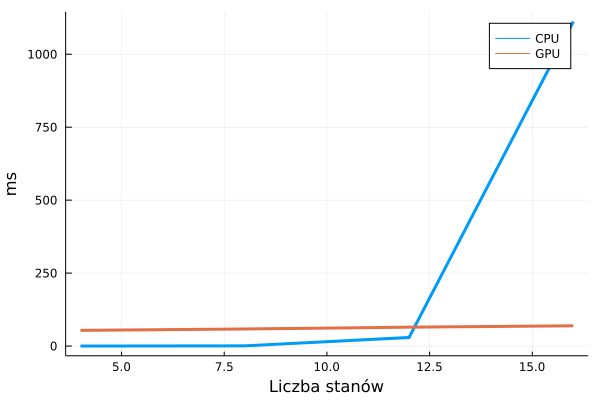

In [247]:
x = 1:10; y = rand(10); # These are the plotting data
plot(ns, [ct, gt], label = ["CPU" "GPU"], lw = 3)
xlabel!("Liczba spinów")
ylabel!("ms")

In [157]:
2^(16-4), (2^4), 2^(16-4)*(2^4)

(4096, 16, 0)

# Check kernel, index, block


In [210]:
# reverse(bitstring(2^64))
# bitstring(2^64-1)

# parseint(bitstring(10))

# for i in 1:12
#     println(bitstring(i))
# end

# bitstring(Int128, 2^128-1)

# typeof(2^128-1) 

# Int64(2^64)

# bitstring(Int128(2^129-2))

bitstring(UInt128(2^128)-2)

"11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110"

In [72]:
bitstring(2)

"0000000000000000000000000000000000000000000000000000000000000010"

In [6]:
const n = 2^20 # 1048576, number of elements in 1D arrays
const THREADS_PER_BLOCK = 256

# create a vector [0.0, 0.0, 0.0...], and send to GPU
C = zeros(Float32, n) |> cu 

# create two vectors, fill them with 1s and 2s, and send to GPU
A = fill(1.0f0, n) |> cu 
B = fill(2.0f0, n) |> cu

function add!(c, a, b)
    # compute the thread_id
    x = (blockIdx().x - 1) * blockDim().x + threadIdx().x 

    # i'th thread should get the i'th elements of a and b 
    # sum them, and then store them in i'th element of c
    @inbounds c[x] = a[x] + b[x]
    return
end

threads = THREADS_PER_BLOCK # 256
blocks = n ÷ threads # 4096

# launch the kernel with 4096 blocks, of 256 threads each
@cuda threads=threads blocks=blocks add!(C, A, B)

CUDA.HostKernel{add!, Tuple{CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x0000000006d8c800, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000003996590, CuModule(Ptr{Nothing} @0x0000000006d8c800, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [7]:
x = zeros(Int8, 500, 20, 200)
# Initialize x
for c = 1:200
    for b = 1:20
        for a = 1:500
            x[a, b, c] = x[a, b, c] + 1
        end
    end
end

In [8]:
x = CUDA.zeros(3,5,7)

function kernel(x)
    a = blockIdx().x
    b = threadIdx().x
    c = threadIdx().y
    x[a, b, c] = a+b+c
    return
end

@cuda blocks=(3,4) threads=(5, 7) kernel(x)


CUDA.HostKernel{kernel, Tuple{CuDeviceArray{Float32, 3, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x00000000072bce90, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000007391ea0, CuModule(Ptr{Nothing} @0x00000000072bce90, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [9]:
x

3×5×7 CuArray{Float32, 3}:
[:, :, 1] =
 3.0  4.0  5.0  6.0  7.0
 4.0  5.0  6.0  7.0  8.0
 5.0  6.0  7.0  8.0  9.0

[:, :, 2] =
 4.0  5.0  6.0  7.0   8.0
 5.0  6.0  7.0  8.0   9.0
 6.0  7.0  8.0  9.0  10.0

[:, :, 3] =
 5.0  6.0  7.0   8.0   9.0
 6.0  7.0  8.0   9.0  10.0
 7.0  8.0  9.0  10.0  11.0

[:, :, 4] =
 6.0  7.0   8.0   9.0  10.0
 7.0  8.0   9.0  10.0  11.0
 8.0  9.0  10.0  11.0  12.0

[:, :, 5] =
 7.0   8.0   9.0  10.0  11.0
 8.0   9.0  10.0  11.0  12.0
 9.0  10.0  11.0  12.0  13.0

[:, :, 6] =
  8.0   9.0  10.0  11.0  12.0
  9.0  10.0  11.0  12.0  13.0
 10.0  11.0  12.0  13.0  14.0

[:, :, 7] =
  9.0  10.0  11.0  12.0  13.0
 10.0  11.0  12.0  13.0  14.0
 11.0  12.0  13.0  14.0  15.0

In [231]:
a = CUDA.zeros(12)

function kernel(a)
    i = blockIdx().x
    a[i] = i
    return
end

@cuda blocks=(2,5) threads=(3,4,5) kernel(a)

CUDA.HostKernel{kernel, Tuple{CuDeviceVector{Float32, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x0000000008a8ab40, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000009618b50, CuModule(Ptr{Nothing} @0x0000000008a8ab40, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [11]:
a

12-element CuArray{Float32, 1}:
 1.0
 2.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

# GPU Shared memory

In [187]:
N = 16

# graph = zeros(2^N)
graph = rand(Uniform(-5,5),N, N)
graph = graph * graph'

graph_dict = Dict()
for i in 1:N
    graph_dict[(i, i)] = graph[i,i] #rand(Uniform(-5,5))
    for j in i:N
        graph_dict[(i, j)] = graph[i,j] #rand(Uniform(-5,5))
    end
end

qubo = zeros(N,N)
constant = 0

for i in 1:N
    qubo[i,i] = 2 * graph[i,i]
    constant += graph[i,i]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph[low,high]*0.5
            qubo[i,i] -= 2*graph[low,high]
            qubo[low,high] += graph[low,high]*2
        end
    end
end

#############

# qubo_dict = Dict()
# constant = 0

# for k in keys(graph_dict)
#    qubo_dict[k] = 0 
# end

# for i in 1:N
#     qubo_dict[(i,i)] = 2 * graph_dict[(i,i)]
#     constant += graph_dict[(i,i)]
    
#     for j in 1:N
#         if i!=j
#             low, high = sort!([i, j])
#             constant -= graph_dict[(low,high)]*0.5
#             qubo_dict[(i,i)] -= 2*graph_dict[(low,high)]
#             qubo_dict[(low,high)] += graph_dict[(low,high)]*2
#         end
#     end
# end

cu_graph = graph |> cu 
cu_qubo = qubo |> cu 

16×16 CuArray{Float32, 2}:
 973.469   31.0652  -298.641  -244.912   …   -46.3275  -140.752     54.7239
   0.0    359.486     27.958    67.1855     -121.054   -238.149    127.343
   0.0      0.0      321.151   163.553       105.383   -258.58     -67.9303
   0.0      0.0        0.0      55.0539       96.0554    36.8197    51.6801
   0.0      0.0        0.0       0.0          -4.4838    77.6508  -256.337
   0.0      0.0        0.0       0.0     …   -34.2552   123.168    213.114
   0.0      0.0        0.0       0.0         136.041    -31.9099  -156.481
   0.0      0.0        0.0       0.0          -4.2655    79.0081    -5.23879
   0.0      0.0        0.0       0.0         -35.2682   260.64      13.1208
   0.0      0.0        0.0       0.0         -93.0565  -131.903    -46.5764
   0.0      0.0        0.0       0.0     …   240.447    -98.1505  -118.463
   0.0      0.0        0.0       0.0        -242.004     52.7818    95.2219
   0.0      0.0        0.0       0.0         -17.2216   245.695  

In [324]:
function energy(graph, state_code)
    F = 0
    N = size(graph)[1]
    q = digits(state_code, base=2, pad=N) #|> reverse

    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = energy(qubo, k)
        res[k] = F
    end

    sort!(res)
end

  949.088 ms (17103879 allocations: 1.52 GiB)


65536-element Vector{Float64}:
 -9495.423762846553
 -9476.627713221453
 -9432.354652016867
 -9413.535020120058
 -9408.322852124684
 -9378.262798525337
 -9353.762536335815
 -9339.101808730024
 -9273.079607518312
 -9273.044906916923
 -9235.746656427858
 -9226.716017633767
 -9186.025847795572
     ⋮
  -190.06232386566478
  -162.46852363857258
  -142.34966085691963
  -110.1078353152499
   -75.41381027981248
   -25.612534750446954
     0.0
    33.60357008442113
    55.55935836388729
   122.65464094819038
   162.64173632293986
   189.5920320129291

In [326]:
# @btime begin

k = 2

function _energy(q, graph)
    F = 0
    N = size(graph)[1]
#     q = digits(state_code, base=2, pad=N) |> reverse
    
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = i < j ? (i, j) : (j, i) 
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

function _decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

function _arginsertsort(A)
    ids = @SVector [i for i in 1:2*2^k] 
    
    for i in 1:length(A)-1
        value = A[ids[i+1]]
        ival = ids[i+1]
        j = i
        while j > 0 && A[ids[j]] > value
#             A[j+1] = A[j]
            @set! ids[j+1] = ids[j]
            j -= 1
        end
#         A[j+1] = value
        @set! ids[j+1] = ival
    end 
    return ids 
end

function _updatearray(ids, A, n)
    tmp = @SVector [0 for i in 1:2*2^k] 
    
    for ii in 1:n
        @set! tmp[ii] = 1 #low_en[ii]
    end

#     for ii in 1:2*2^k
#         low_en[ii] = tmp[ids[ii]]
#     end
    
    return
end

function _energy2(state_code, graph)
    F = 0
    N = size(graph)[1]
    
    sc1 = state_code    
    for i in 1:N
        qi = sc1%2
        sc1 = div(sc1,2)
        
        F -= graph[i,i]*qi  
        
        sc2 = state_code
        for j in 1:N
            qj = sc2%2
            sc2 = div(sc2,2)
                       
            low, high = i < j ? (i, j) : (j, i) 
            F -= graph[low,high]*qi*qj
        end
    end
    return F
end

function kernel(qubo, low_en, low_st, part_lst)
    threadsPerBlock = blockDim().x
    nr_of_block = gridDim().x

    N = size(qubo)[1]

    i = blockIdx().x
    j = threadIdx().x

    state_code = (i - 1) * blockDim().x + j 

    F = _energy2(state_code, qubo) |> Float32
    
    low_en[state_code] = F
    
    sync_threads()
    
#     @cuprintln(nr_of_block*blockDim().x)
    
    if j == 1
        k = (i - 1) * blockDim().x + 1
        n = blockDim().x
        
#         for ii in k:k+n-1
#             value = low_en[ii+1]
#             jj = ii
#             while jj > 0 && low_en[jj] > value
#                 low_en[jj+1] = low_en[jj]
#                 jj -= 1
#             end
#             low_en[i] = value
#         end 
        
        value=low_en[k]
        for ii in k:k+n-1
#         for ii in k:nr_of_block*blockDim().x
            if value > low_en[ii]
                value = low_en[ii]
            end
        end 
               
        sync_threads()
        
#         @cuprintln(i)
        part_lst[i] = value # low_en[k]
#         part_lst[i+nr_of_block] = low_en[k+1]
    end
        
    return
end

# @btime begin
function main()
    k = 2
    
    low_en = CUDA.zeros(2^N) #CUDA.zeros(2*2^k)
    low_st = CUDA.zeros(2*2^k)
    part_lst = CUDA.zeros(2^(N-k))
   
    threadsPerBlock::Int64 = 2^k
    blocksPerGrid::Int64 = 2^(N-k)

    @cuda blocks=(blocksPerGrid) threads=(threadsPerBlock) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st, part_lst)

    #     CUDA.@device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)

    #     CUDA.@device_code_typed @cuda blocks=(1) threads=(2^k) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st)
    
    #     bitonicsort!(low_en)
#     sort!(low_en)
#     CUDA.sort!(low_en)
#     low_en
    sort!(part_lst)
#     part_lst
#     2^N
end

@btime begin
    main()
end

main()

  19.050 μs (105 allocations: 3.64 KiB)


16384-element CuArray{Float32, 1}:
 -9495.423
 -9476.627
 -9432.355
 -9413.536
 -9408.322
 -9378.262
 -9353.762
 -9339.102
 -9273.079
 -9273.044
 -9235.747
 -9226.716
 -9186.025
     ⋮
 -1887.8053
 -1885.7644
 -1882.0793
 -1878.5049
 -1848.3147
 -1802.6051
 -1773.7521
 -1734.8325
 -1730.9148
 -1681.4109
 -1587.6548
 -1405.7335

In [327]:
function kernel(qubo, low_en, low_st, part_lst)
    threadsPerBlock = blockDim().x
    nr_of_block = gridDim().x

    N = size(qubo)[1]

    i = blockIdx().x
    j = threadIdx().x

    state_code = (i - 1) * blockDim().x + j 

    F = _energy2(state_code, qubo) |> Float32
    
    low_en[state_code] = F
        
    return
end

# @btime begin
function main()
    k = 2
    
    low_en = CUDA.zeros(2^N) #CUDA.zeros(2*2^k)
    low_st = CUDA.zeros(2*2^k)
    part_lst = CUDA.zeros(2^(N-k))
   
    threadsPerBlock::Int64 = 2^k
    blocksPerGrid::Int64 = 2^(N-k)

    @cuda blocks=(blocksPerGrid) threads=(threadsPerBlock) shmem = (2^k * sizeof(Float64)) kernel(cu_qubo, low_en, low_st, part_lst)

    sort!(low_en)
end

@btime begin
    main()
end

main()

  17.919 μs (105 allocations: 3.64 KiB)


65536-element CuArray{Float32, 1}:
 -9495.423
 -9476.627
 -9432.355
 -9413.536
 -9408.322
 -9378.262
 -9353.762
 -9339.102
 -9273.079
 -9273.044
 -9235.747
 -9226.716
 -9186.025
     ⋮
  -190.06235
  -162.46852
  -142.34966
  -110.107834
   -75.41381
   -25.612541
     0.0
    33.60357
    55.559357
   122.65464
   162.64174
   189.59204

In [129]:
7.116/1000,7.394/1000,8.107/1000,8.604/1000,8.867/1000,185.790

(0.007116, 0.007394, 0.008107, 0.008603999999999999, 0.008867000000000002, 185.79)

In [43]:
65536-element Vector{Float64}:
 -9495.423762846553
 -9476.627713221453
 -9432.354652016867
 -9413.535020120058
 -9408.322852124684
 -9378.262798525337
 -9353.762536335815
 -9339.101808730024
 -9273.079607518312
 -9273.044906916923
 -9235.746656427858
 -9226.716017633767
 -9186.025847795572
     ⋮
  -190.06232386566478
  -162.46852363857258
  -142.34966085691963
  -110.1078353152499
   -75.41381027981248
   -25.612534750446954
     0.0
    33.60357008442113
    55.55935836388729
   122.65464094819038
   162.64173632293986
   189.5920320129291

LoadError: syntax: extra token "Vector" after end of expression

In [198]:
4:7.116/1000
8:7.394/1000
12:8.107/1000
16:8.604/1000
20:8.867/1000
24:185.790


4:14.721/1000, 
8:15.451/1000, 
12:16.041/1000, 
16:16.764/1000, 
20:18.823/1000, 
24:749.470

(4.0:1.0:3.0, 8.0:1.0:7.0, 12.0:1.0:11.0, 16.0:1.0:15.0, 20.0:1.0:19.0, 24.0:1.0:749.0)

In [9]:
a = [12,-3,4,8,4]

insertsort(a)

5-element Vector{Int64}:
 -3
  4
  4
  8
 12

In [131]:
cu_qubo

28×28 CuArray{Float32, 2}:
 -99.158   87.1292   221.541     2.2529  …    13.5666    19.7814   119.884
   0.0    250.172   -107.374  -121.882        86.7759   115.249    142.376
   0.0      0.0      616.678   -71.7574     -371.397    -38.6793    40.7271
   0.0      0.0        0.0     850.902       154.003    238.18     -29.3444
   0.0      0.0        0.0       0.0          30.4149   197.429     42.3459
   0.0      0.0        0.0       0.0     …  -157.295    -52.0187   314.308
   0.0      0.0        0.0       0.0         163.854   -316.463   -132.31
   0.0      0.0        0.0       0.0         199.685    134.601   -186.426
   0.0      0.0        0.0       0.0         233.681   -180.583    -18.0202
   0.0      0.0        0.0       0.0          98.4093   -46.0952  -168.605
   0.0      0.0        0.0       0.0     …  -307.331   -185.273     76.6389
   0.0      0.0        0.0       0.0          42.8293    30.9511  -165.677
   0.0      0.0        0.0       0.0        -380.017   -229.791    22